# Field Transformation HMC: `ftHMC`

### Imports

In [1]:
import os
import sys
import torch

from functools import reduce
from IPython.core.interactiveshell import InteractiveShell

%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format ='retina'

InteractiveShell.ast_node_interactivity = "all"


project_dir = os.path.abspath('../../')
if project_dir not in sys.path:
    sys.path.append(project_dir)

import fthmc.utils.io as io
logger = io.Logger()

torch.manual_seed(9)
# torch.set_default_tensor_type(torch.FloatTensor)

#torch.set_num_threads(param.nth)
#torch.set_num_interop_threads(param.nth_interop)
#os.environ["OMP_NUM_THREADS"] = str(param.nth)
#os.environ["KMP_BLOCKTIME"] = "0"
#os.environ["KMP_SETTINGS"] = "1"
#os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

import matplotlib as mpl
import matplotlib.pyplot as plt

from fthmc.train import train
from fthmc.config import Param, TrainConfig, PI
from fthmc.utils.distributions import MultivariateUniform
from fthmc.utils.layers import make_u1_equiv_layers, set_weights
from fthmc.utils.plot_helpers import save_live_plots
from fthmc.utils.logger import Logger

import fthmc.utils.qed_helpers as qed

import datetime

from fthmc.config import LOGS_DIR

mpl.rcParams['text.usetex'] = False
%matplotlib inline

style_file = os.path.abspath('~/.matplotlib/stylelib/molokai.mplstyle')
if os.path.isfile(style_file):
    plt.style.use('~/.matplotlib/stylelib/molokai.mplstyle')
    plt.style.use(style_file)

[17:21:32]  TORCH DEVICE: cuda

            TORCH DTYPE: torch.float32

In [2]:
import seaborn as sns

#sns.set_palette('bright')
sns.set_style('whitegrid')
colors = ['#228BE6', '#FA5252', '#40C057',
          '#FF920B', '#BE4BDB', '#FAB005',
          '#E64980', '#6A777E', '#4C6EF5']
sns.set_palette(colors)

## Define `Param` and `TrainConfig` for training the flow

In [3]:
import numpy as np

from fthmc.config import SchedulerConfig
from fthmc.main import main

#plt.style.use('~/.matplotlib/stylelib/molokai.mplstyle')

L = 8 
BETA = 2.

# -------------------------------------------
# Specify `param` and `train_config` objects
# -------------------------------------------
param = Param(**{
    'L': L, 
    'tau': 0.5,
    'nrun': 1,
    'beta': BETA,
    'nstep': 5,
    'ntraj': 1000,
    'nprint': 100,
    'seed': 1331,
    #'nth': 0,
    #'nth_interop': 0
})

train_config = TrainConfig(**{
    'L': L,
    'beta': BETA,
    'n_era': 10,
    'n_epoch': 100,
    'activation_fn': 'leaky_relu',
    'n_layers': 16,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8],
    'kernel_size': 3,
    'batch_size': 64,
    'print_freq': 100,
    'plot_freq': 50,
    'log_freq': 50,
})

scheduler_config = SchedulerConfig(**{
    'factor': 0.95,
    'patience': 50,
    'min_lr': 5e-6,
    'verbose': True,
})

os.environ["KMP_BLOCKTIME"] = "0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= (
    "granularity=fine,verbose,compact,1,0"
)
#torch.set_num_threads(int(param.nth))
#torch.set_num_interop_threads(int(param.nth_interop))
#os.environ["OMP_NUM_THREADS"] = str(param.nth)

## Run HMC using `Param` defined above

───────────────────── Running HMC for 1 runs, of 1000 trajectories each ─────────────────────

[16:11:47]  Creating directory:                                                              
            ../../logs/hmc/lat8x8/beta1.0/t8x8_b1.0_n1000_t0.5_s5/2021-06-30-161147

[16:11:47]  Creating directory:                                                              
            ../../logs/hmc/lat8x8/beta1.0/t8x8_b1.0_n1000_t0.5_s5/2021-06-30-161147/plots

[16:11:47]  Param:                                                                           
            ----------------                                                                 
            beta=1.0                                                                         
            L=8                                                                              
            tau=0.5                                                                          
            nstep=5                                                                          
            ntraj=1000                                                                       
            nrun=1                                                                           
            nprint=100                                                                       
            seed=1331                                                                        
            randinit=False                                                                   
            nth_interop=2                                                                    
            nth=2                                                                            
            lat=[8, 8]                                                                       
            nd=2                                                                             
            shape=[2, 8, 8]                                                                  
            volume=64                                                                        
            dt=0.1                                                                           
            logdir=/lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta1.0/t8x8_b1.0_n
            1000_t0.5_s5

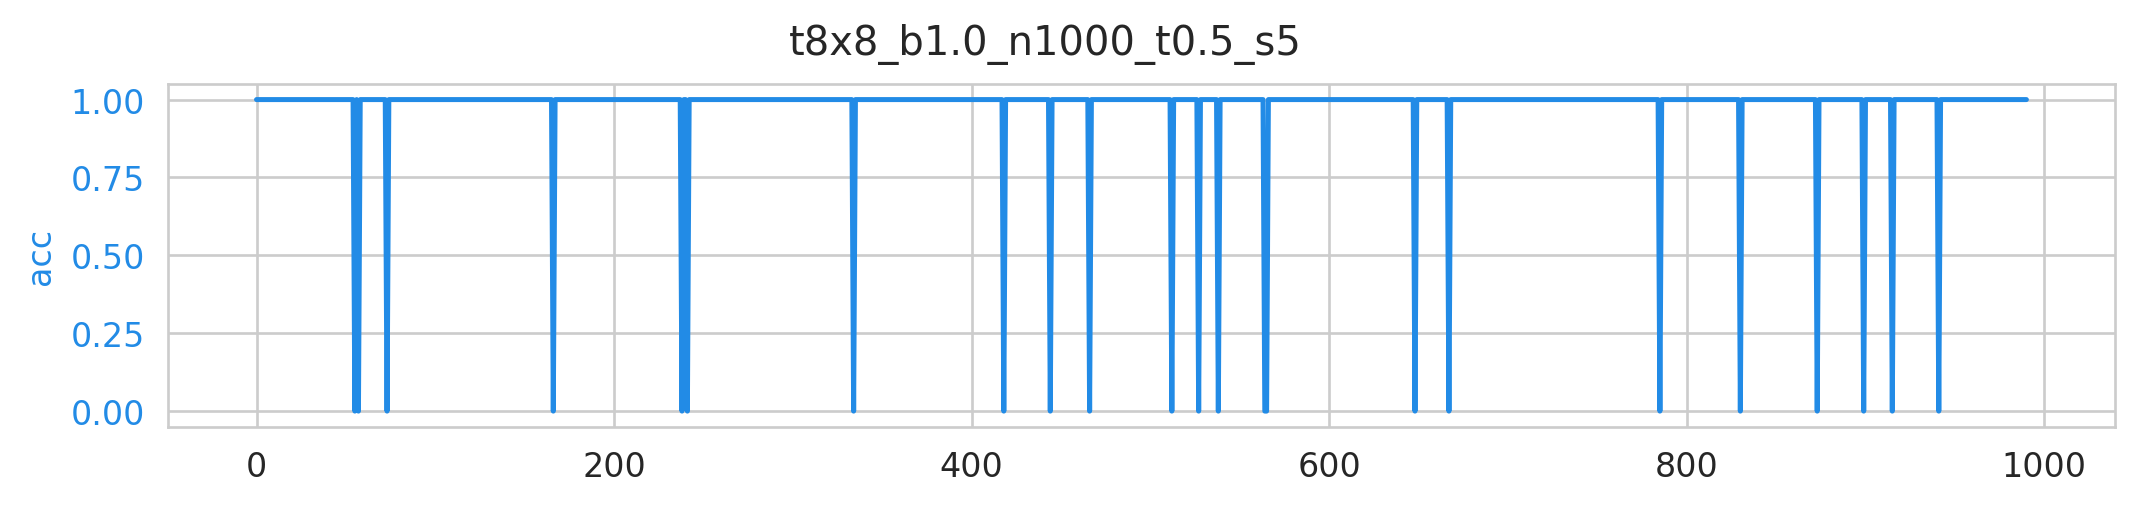

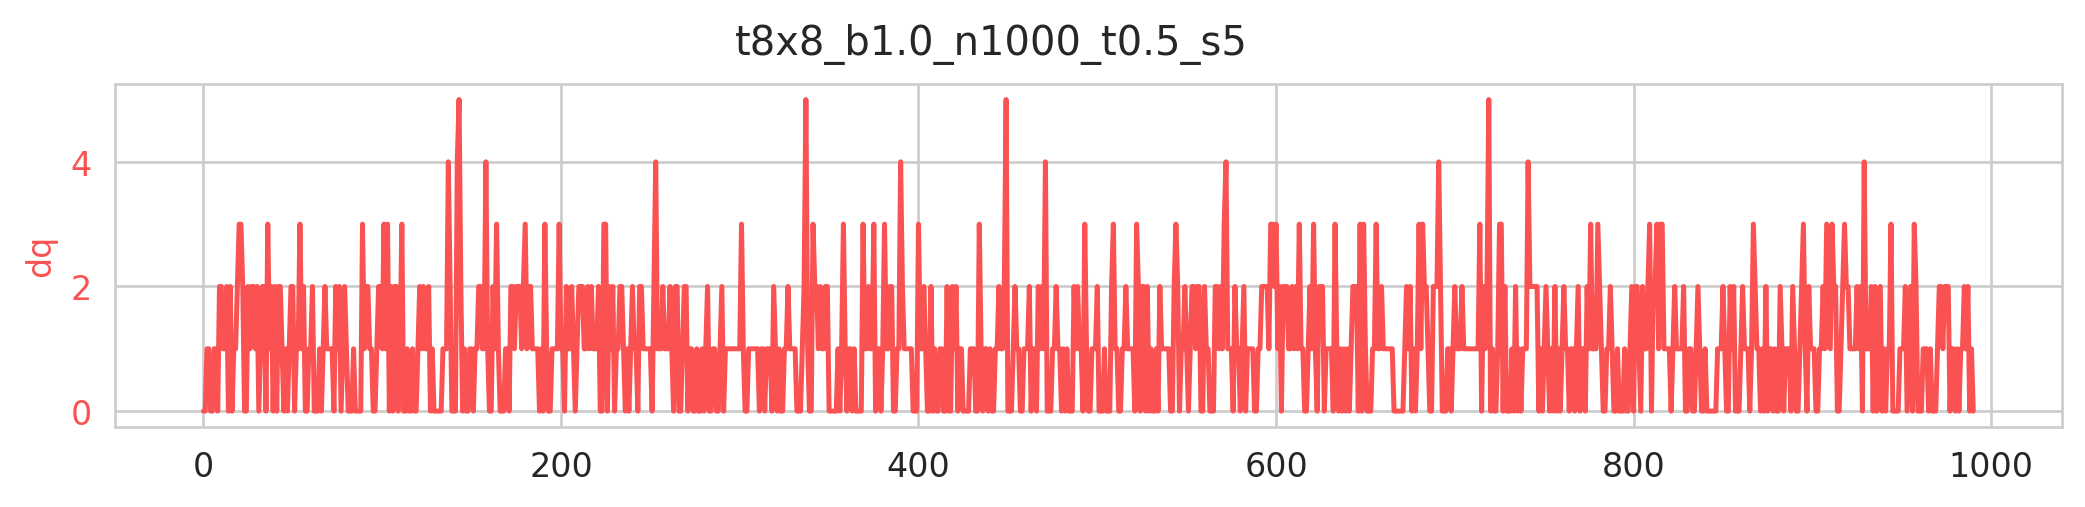

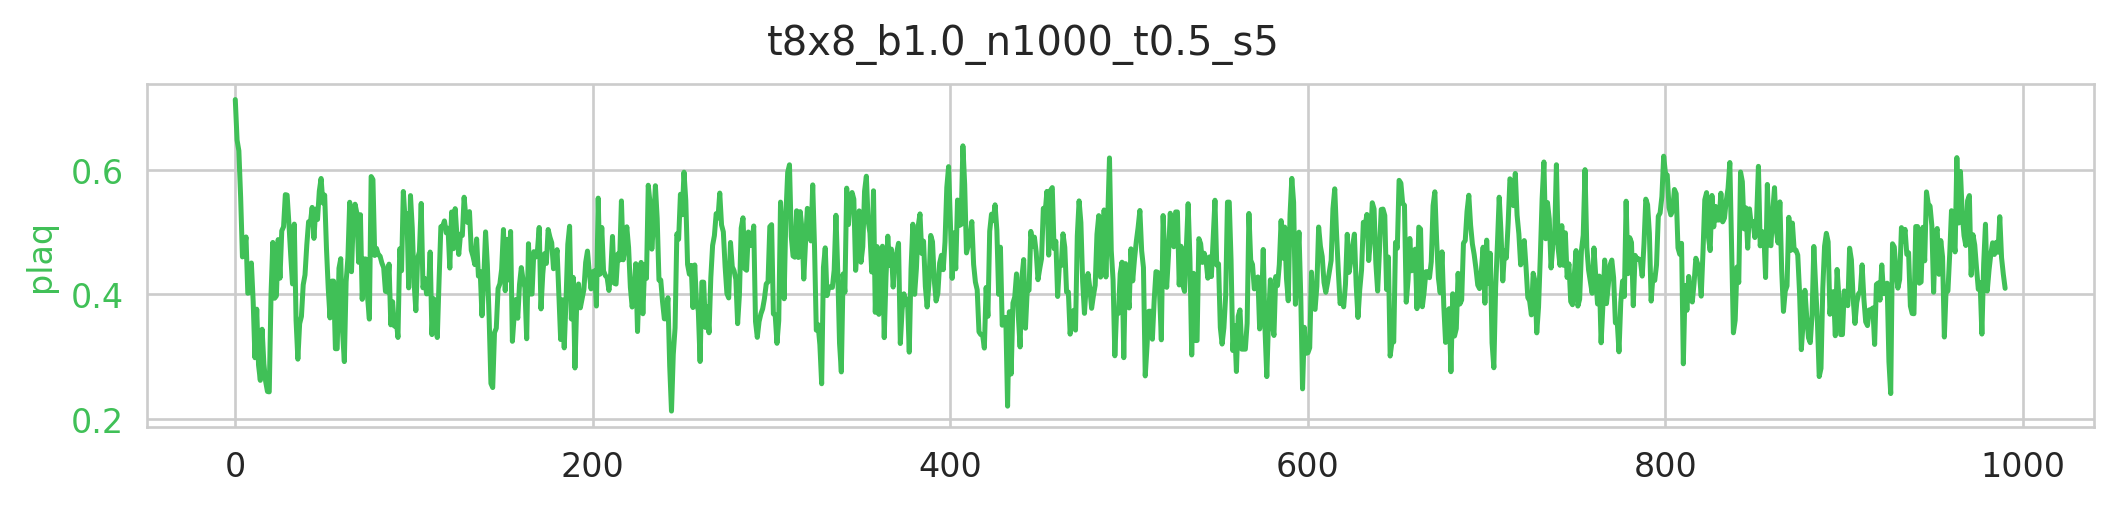

──────────────────────────────── RUN: 0, last took: 0 m 0 s ─────────────────────────────────

[16:11:49]  plaq=1.000 q=0.000

            traj=2 dt=0.004 acc=1.000 dH=-0.017 plaq=0.648 q=0 dq=0.000

[16:11:55]  traj=102 dt=0.005 acc=1.000 dH=0.013 plaq=0.373 q=0 dq=3.000

[16:12:01]  traj=202 dt=0.004 acc=1.000 dH=0.030 plaq=0.438 q=0 dq=1.000

[16:12:07]  traj=302 dt=0.004 acc=1.000 dH=-0.073 plaq=0.368 q=-3 dq=3.000

[16:12:13]  traj=402 dt=0.004 acc=1.000 dH=-0.019 plaq=0.425 q=-3 dq=1.000

[16:12:19]  traj=502 dt=0.005 acc=1.000 dH=0.025 plaq=0.473 q=-1 dq=0.000

[16:12:25]  traj=602 dt=0.004 acc=1.000 dH=0.006 plaq=0.314 q=0 dq=1.000

[16:12:31]  traj=702 dt=0.004 acc=1.000 dH=-0.032 plaq=0.417 q=0 dq=1.000

[16:12:38]  traj=802 dt=0.004 acc=1.000 dH=-0.011 plaq=0.592 q=3 dq=2.000

[16:12:44]  traj=902 dt=0.005 acc=1.000 dH=0.004 plaq=0.384 q=1 dq=1.000

[16:12:49]  Creating directory: ../../logs/hmc/lat8x8/beta1.0/t8x8_b1.0_n1000_t0.5_s5/2021-06
            -30-161147/plots/run0

[16:12:49]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta1.0/
            t8x8_b1.0_n1000_t0.5_s5/2021-06-30-161147/plots/run0/traj.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta1.0/
            t8x8_b1.0_n1000_t0.5_s5/2021-06-30-161147/plots/run0/dt.png

[16:12:50]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta1.0/
            t8x8_b1.0_n1000_t0.5_s5/2021-06-30-161147/plots/run0/acc.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta1.0/
            t8x8_b1.0_n1000_t0.5_s5/2021-06-30-161147/plots/run0/dH.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta1.0/
            t8x8_b1.0_n1000_t0.5_s5/2021-06-30-161147/plots/run0/plaq.png

[16:12:51]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta1.0/
            t8x8_b1.0_n1000_t0.5_s5/2021-06-30-161147/plots/run0/q.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta1.0/
            t8x8_b1.0_n1000_t0.5_s5/2021-06-30-161147/plots/run0/dq.png

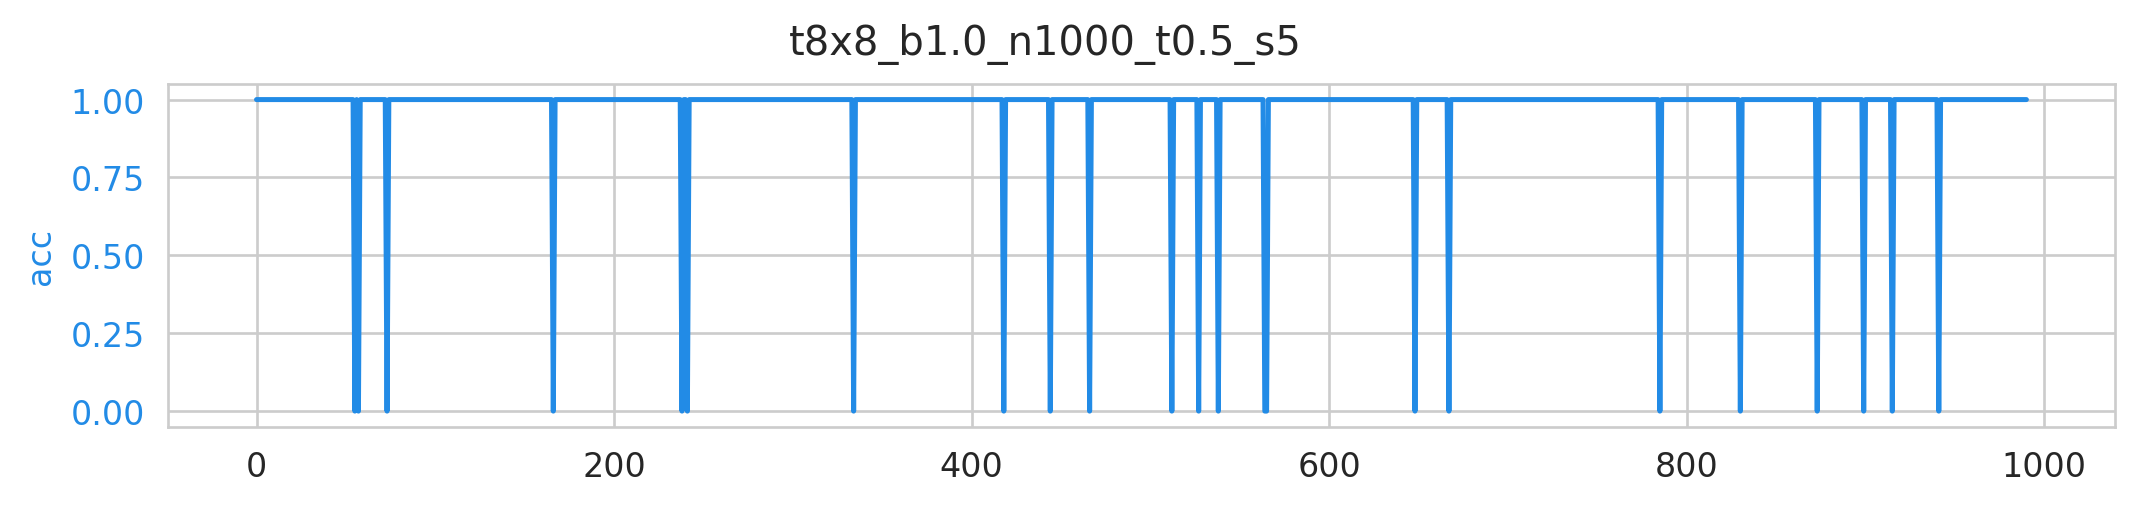

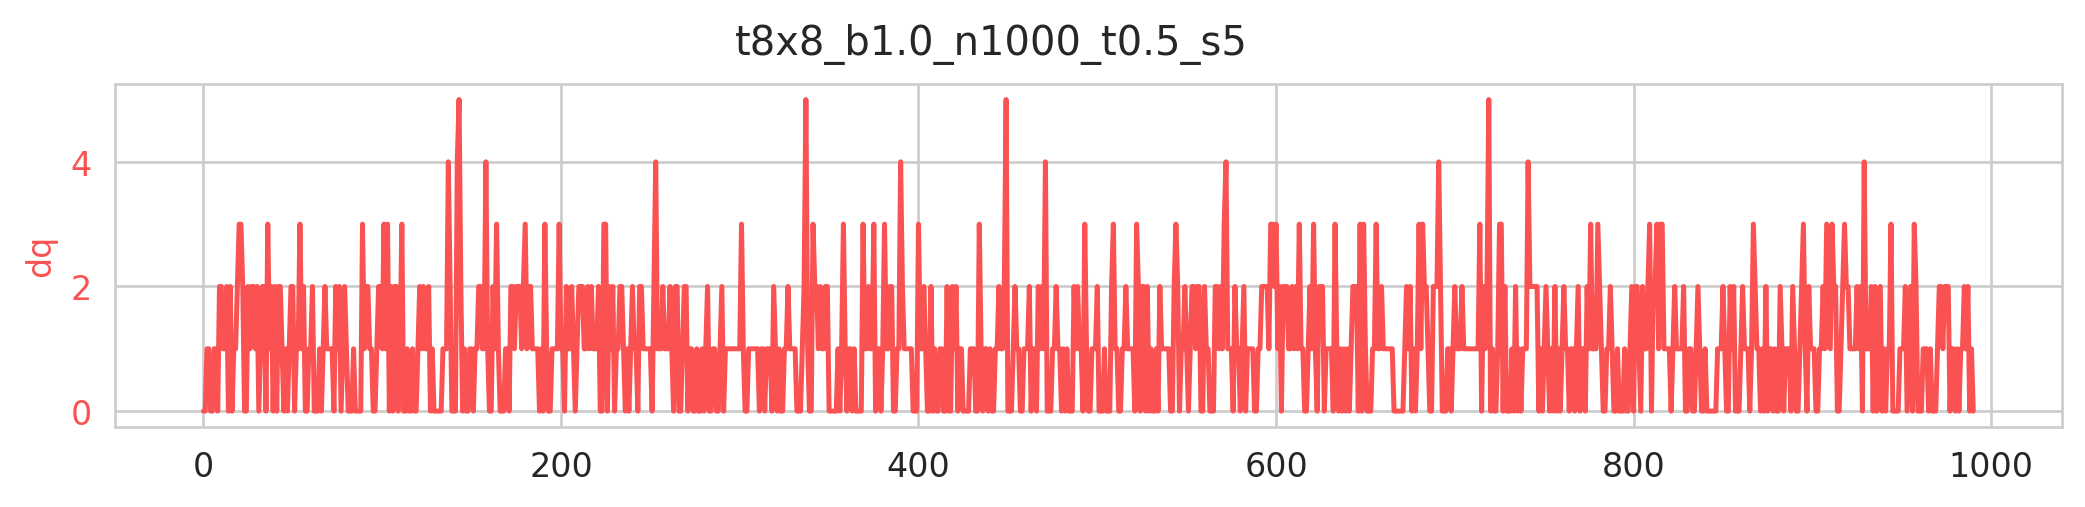

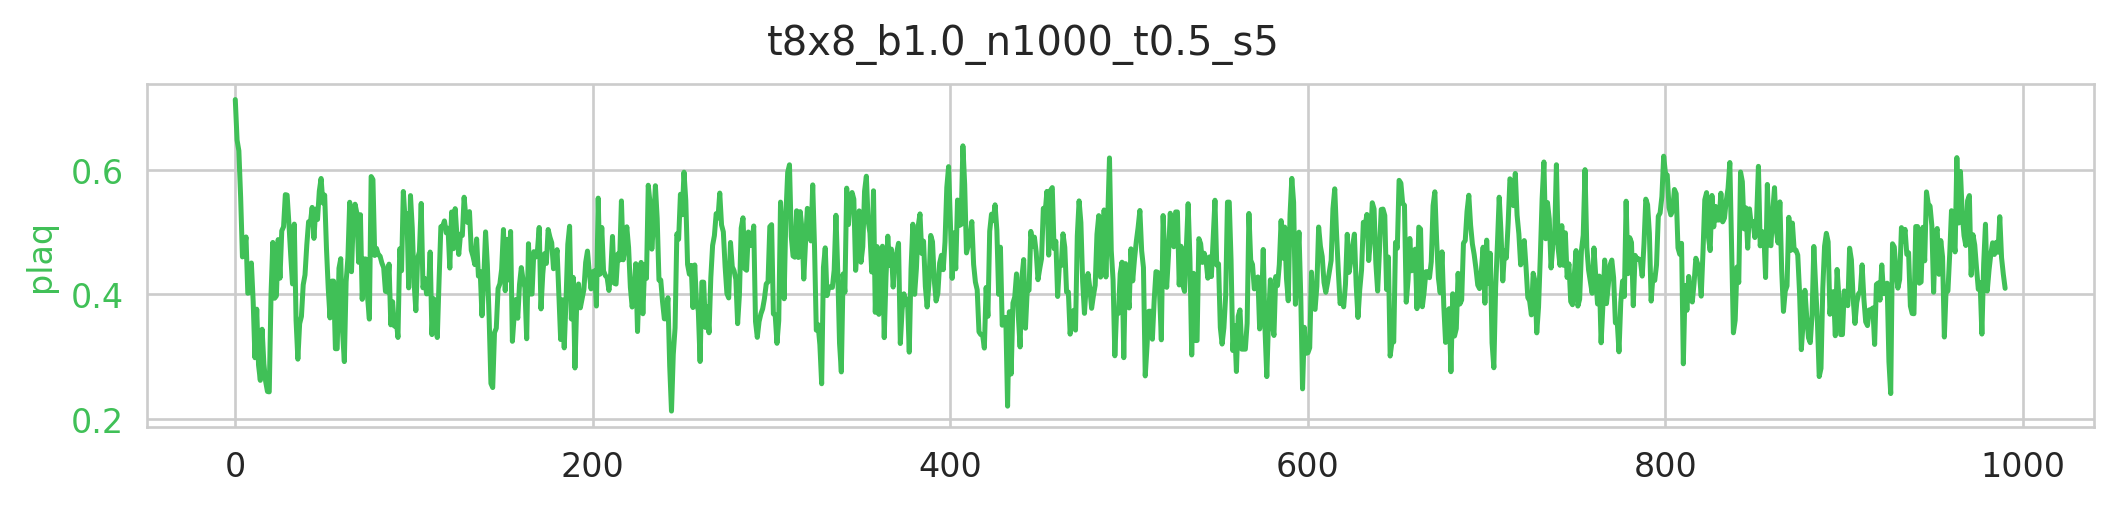

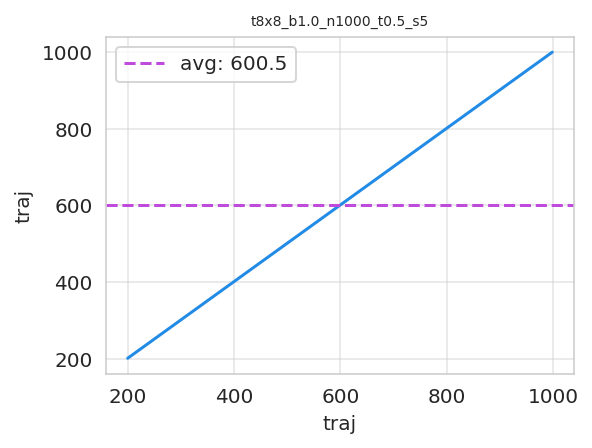

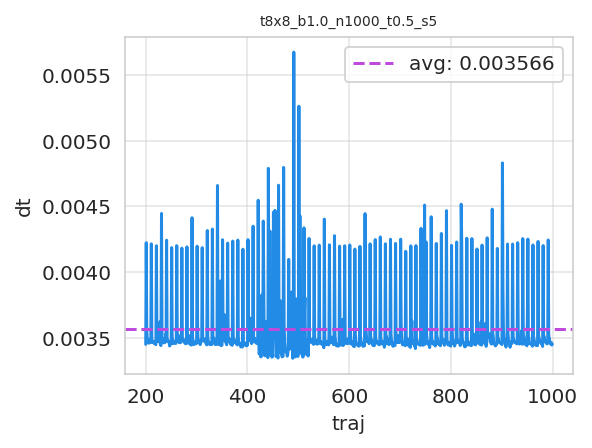

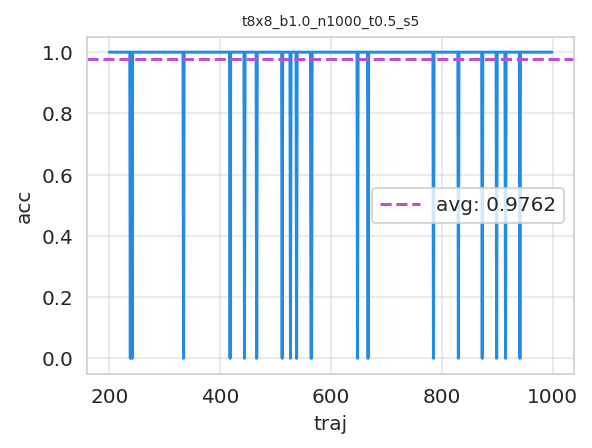

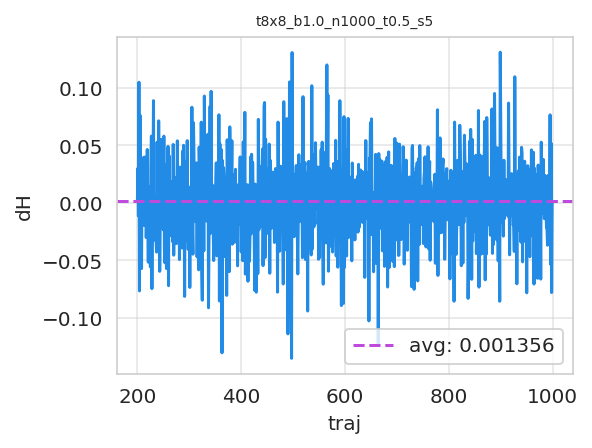

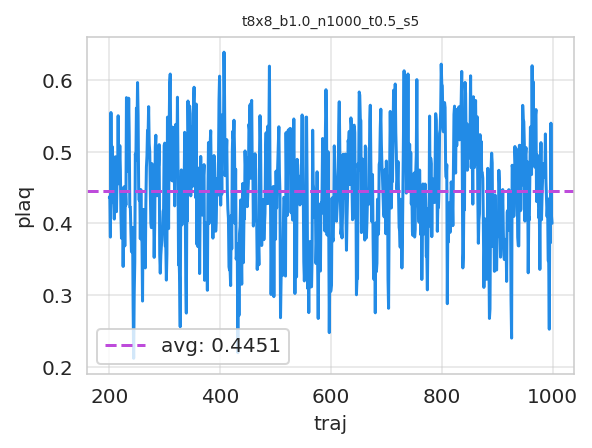

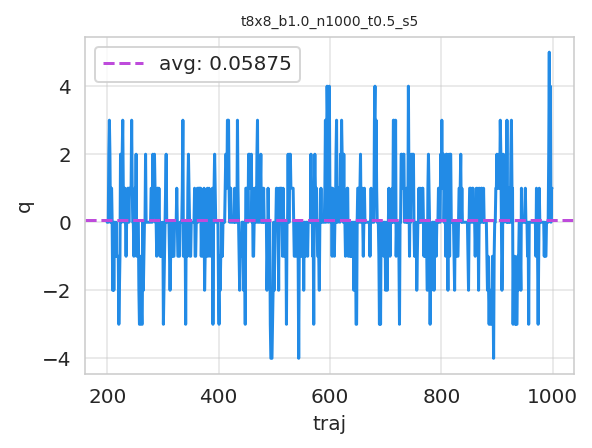

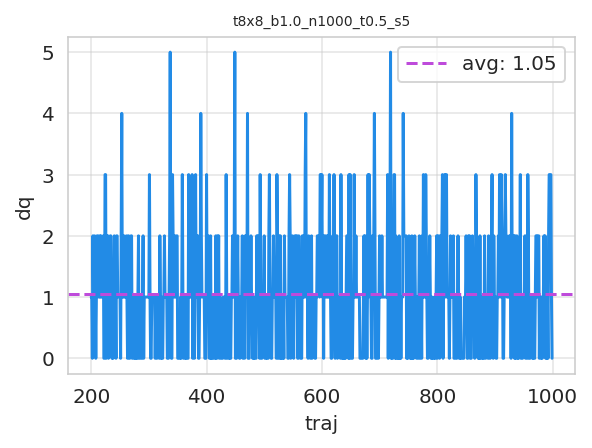

[16:12:52]  Run times: ['61.7733']

            Per trajectory: ['0.0618']

[16:12:52]  Saving hmc_histories to ../../logs/hmc/lat8x8/beta1.0/t8x8_b1.0_n1000_t0.5_s5/202
            1-06-30-161147/hmc_histories.z.

[16:12:53]  Saving hmc_fields_arr to ../../logs/hmc/lat8x8/beta1.0/t8x8_b1.0_n1000_t0.5_s5/20
            21-06-30-161147/hmc_fields_arr.z.

In [5]:
from fthmc.hmc import run_hmc
#plt.style.use('/home/foremans/.matplotlib/stylelib/molokai.mplstyle')

logger.rule(f'Running HMC for {param.nrun} runs, '
            f'of {param.ntraj} trajectories each')
hmc_fields, hmc_history = run_hmc(param, plot_metrics=True, figsize=(9, 2.))

## Train flow model using `TrainConfig` and `SchedulerConfig` defined above

In [11]:
train_config.base_lr = 1e-4

─────────────────────── Training FlowModel for 10 eras and 100 epochs ───────────────────────

[17:22:22]  Creating directory: ../../logs/models/lat8x8/beta2.0/L8_b2.0_nb64_actleaky_relu_n
            h16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-06-30-172222

[17:22:22]  Creating directory: ../../logs/models/lat8x8/beta2.0/L8_b2.0_nb64_actleaky_relu_n
            h16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-06-30-172222/plots

[17:22:22]  Creating directory: ../../logs/models/lat8x8/beta2.0/L8_b2.0_nb64_actleaky_relu_n
            h16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-06-30-172222/checkpoints

[17:22:22]  Creating directory: ../../logs/models/lat8x8/beta2.0/L8_b2.0_nb64_actleaky_relu_n
            h16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-06-30-172222/summaries

[17:22:24]  Writing summaries to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/summaries

            Scheduler created!

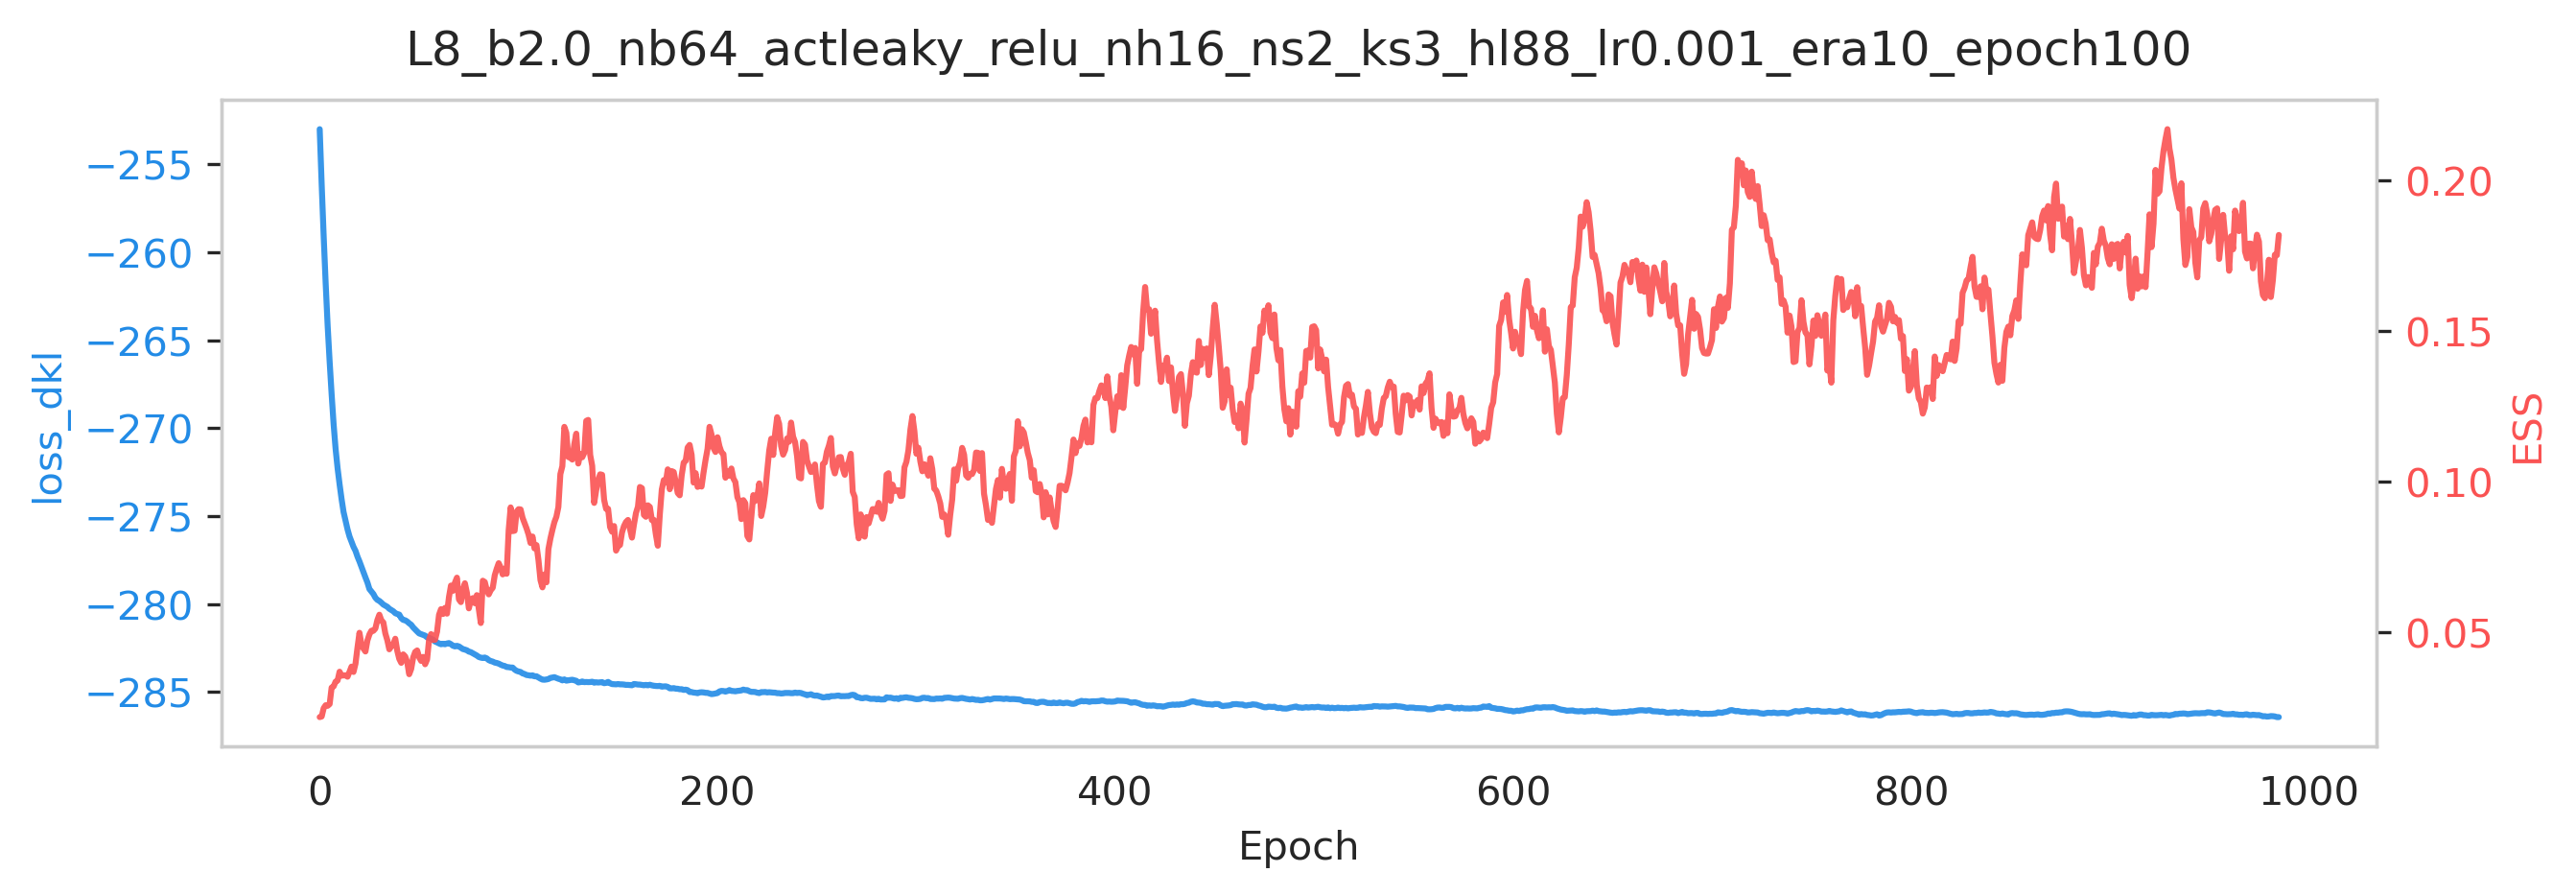

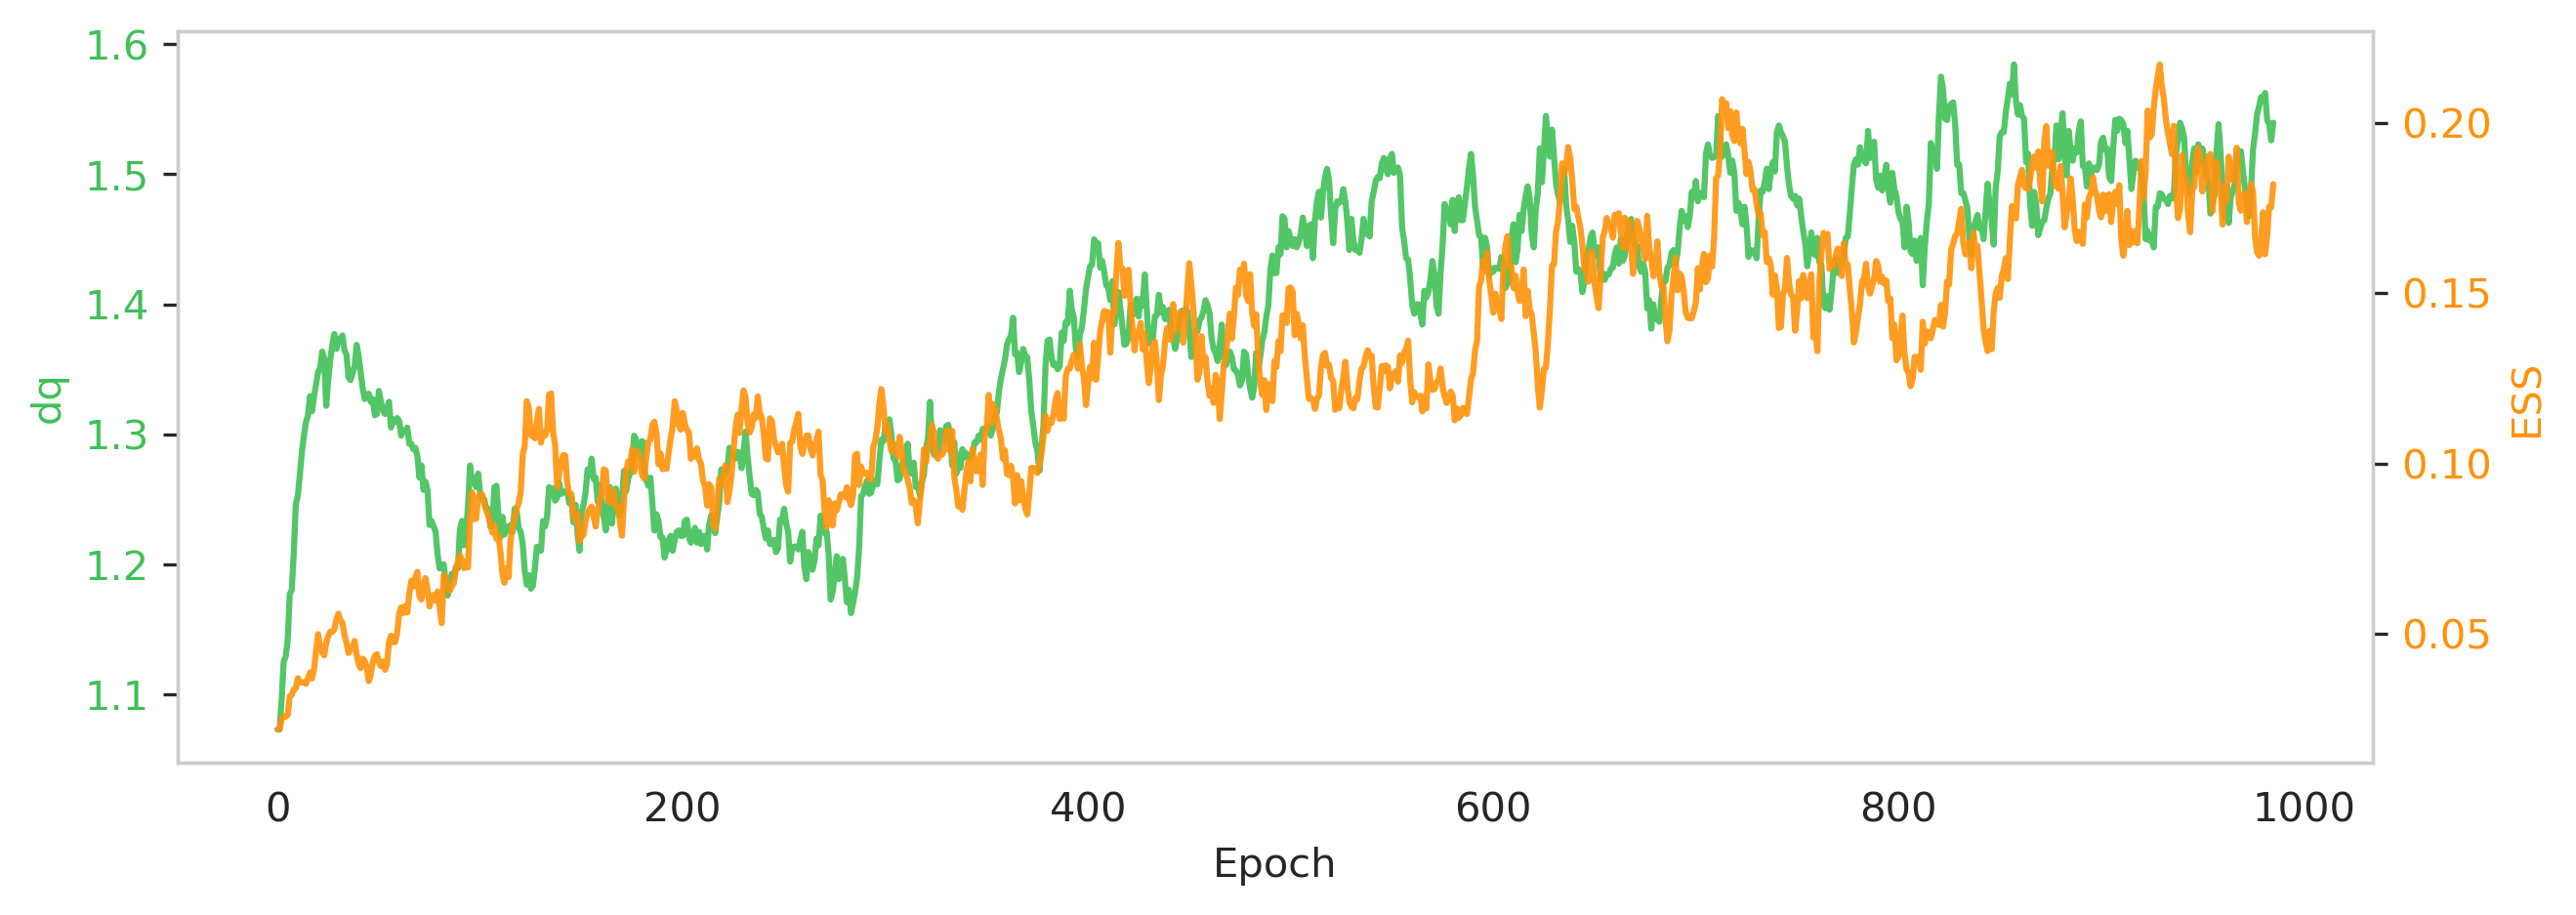

─────────────────────────────── ERA=0, last took: 0 min 0 sec ───────────────────────────────

[17:22:35]  epoch=100 dt=0.084 ess=0.018 logp=78.599 logq=-204.945 loss_dkl=-283.544 dq=1.359
            plaq=0.614

[17:22:36]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/checkpoints/ckpt-era0-epoch99.tar

───────────────────────────── ERA=1, last took: 0 min 11.83 sec ─────────────────────────────

[17:22:45]  epoch=200 dt=0.081 ess=0.119 logp=80.970 logq=-204.065 loss_dkl=-285.035 dq=1.156
            plaq=0.633

[17:22:46]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/checkpoints/ckpt-era1-epoch99.tar

───────────────────────────── ERA=2, last took: 0 min 9.687 sec ─────────────────────────────

Epoch   242: reducing learning rate of group 0 to 9.5000e-04.


[17:22:55]  epoch=300 dt=0.081 ess=0.222 logp=82.103 logq=-202.896 loss_dkl=-284.999 dq=1.219
            plaq=0.641

[17:22:55]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/checkpoints/ckpt-era2-epoch99.tar

───────────────────────────── ERA=3, last took: 0 min 9.564 sec ─────────────────────────────

Epoch   336: reducing learning rate of group 0 to 9.0250e-04.
Epoch   387: reducing learning rate of group 0 to 8.5737e-04.


[17:23:04]  epoch=400 dt=0.082 ess=0.075 logp=84.630 logq=-201.133 loss_dkl=-285.764 dq=1.234
            plaq=0.661

[17:23:05]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/checkpoints/ckpt-era3-epoch99.tar

───────────────────────────── ERA=4, last took: 0 min 9.789 sec ─────────────────────────────

Epoch   438: reducing learning rate of group 0 to 8.1451e-04.
Epoch   489: reducing learning rate of group 0 to 7.7378e-04.


[17:23:14]  epoch=500 dt=0.081 ess=0.044 logp=83.180 logq=-202.537 loss_dkl=-285.717 dq=1.562
            plaq=0.650

[17:23:15]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/checkpoints/ckpt-era4-epoch99.tar

───────────────────────────── ERA=5, last took: 0 min 9.617 sec ─────────────────────────────

Epoch   540: reducing learning rate of group 0 to 7.3509e-04.
Epoch   591: reducing learning rate of group 0 to 6.9834e-04.


[17:23:24]  epoch=600 dt=0.083 ess=0.151 logp=83.623 logq=-202.117 loss_dkl=-285.739 dq=1.422
            plaq=0.653

[17:23:25]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/checkpoints/ckpt-era5-epoch99.tar

───────────────────────────── ERA=6, last took: 0 min 9.845 sec ─────────────────────────────

Epoch   642: reducing learning rate of group 0 to 6.6342e-04.
Epoch   693: reducing learning rate of group 0 to 6.3025e-04.


[17:23:34]  epoch=700 dt=0.084 ess=0.086 logp=84.887 logq=-201.019 loss_dkl=-285.906 dq=1.359
            plaq=0.663

[17:23:35]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/checkpoints/ckpt-era6-epoch99.tar

───────────────────────────── ERA=7, last took: 0 min 10.08 sec ─────────────────────────────

Epoch   744: reducing learning rate of group 0 to 5.9874e-04.


[17:23:44]  epoch=800 dt=0.084 ess=0.075 logp=84.051 logq=-201.774 loss_dkl=-285.825 dq=1.500
            plaq=0.657

[17:23:45]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/checkpoints/ckpt-era7-epoch99.tar

───────────────────────────── ERA=8, last took: 0 min 10.04 sec ─────────────────────────────

Epoch   834: reducing learning rate of group 0 to 5.6880e-04.
Epoch   885: reducing learning rate of group 0 to 5.4036e-04.


[17:23:54]  epoch=900 dt=0.087 ess=0.179 logp=86.366 logq=-200.256 loss_dkl=-286.622 dq=1.375
            plaq=0.675

[17:23:55]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/checkpoints/ckpt-era8-epoch99.tar

───────────────────────────── ERA=9, last took: 0 min 9.91 sec ──────────────────────────────

[17:24:04]  epoch=1000 dt=0.084 ess=0.220 logp=86.192 logq=-200.244 loss_dkl=-286.437        
            dq=1.563 plaq=0.673

[17:24:05]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/checkpoints/ckpt-era9-epoch99.tar

            Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/checkpoints/ckpt-era10-epoch101.tar

[17:24:05]  Saving live plots to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/b
            eta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/traini
            ng/2021-06-30-172222/plots

[17:24:06]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2
            021-06-30-172222/plots/dt.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2
            021-06-30-172222/plots/ess.png

[17:24:07]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2
            021-06-30-172222/plots/logp.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2
            021-06-30-172222/plots/logq.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2
            021-06-30-172222/plots/loss_dkl.png

[17:24:08]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2
            021-06-30-172222/plots/q.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2
            021-06-30-172222/plots/dq.png

[17:24:09]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2
            021-06-30-172222/plots/plaq.png

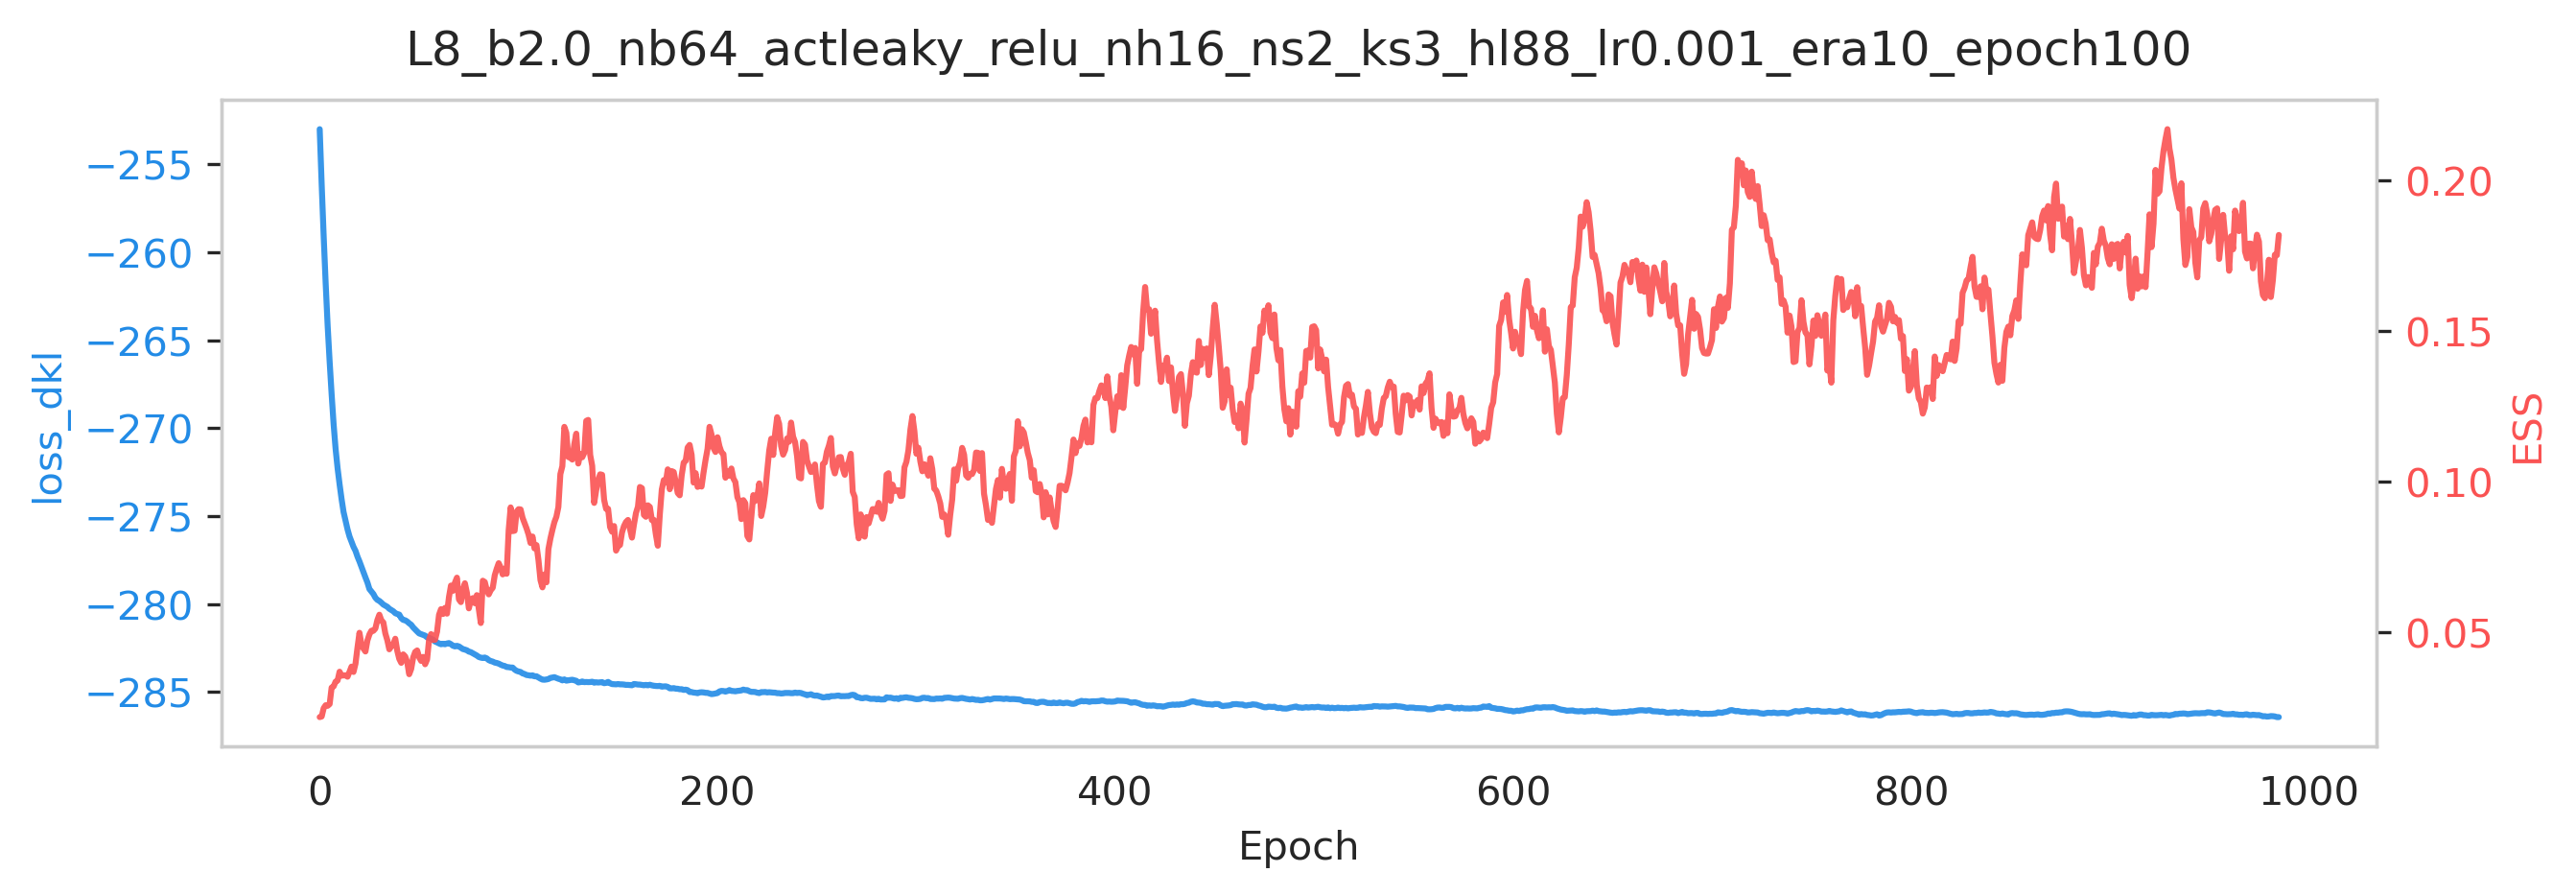

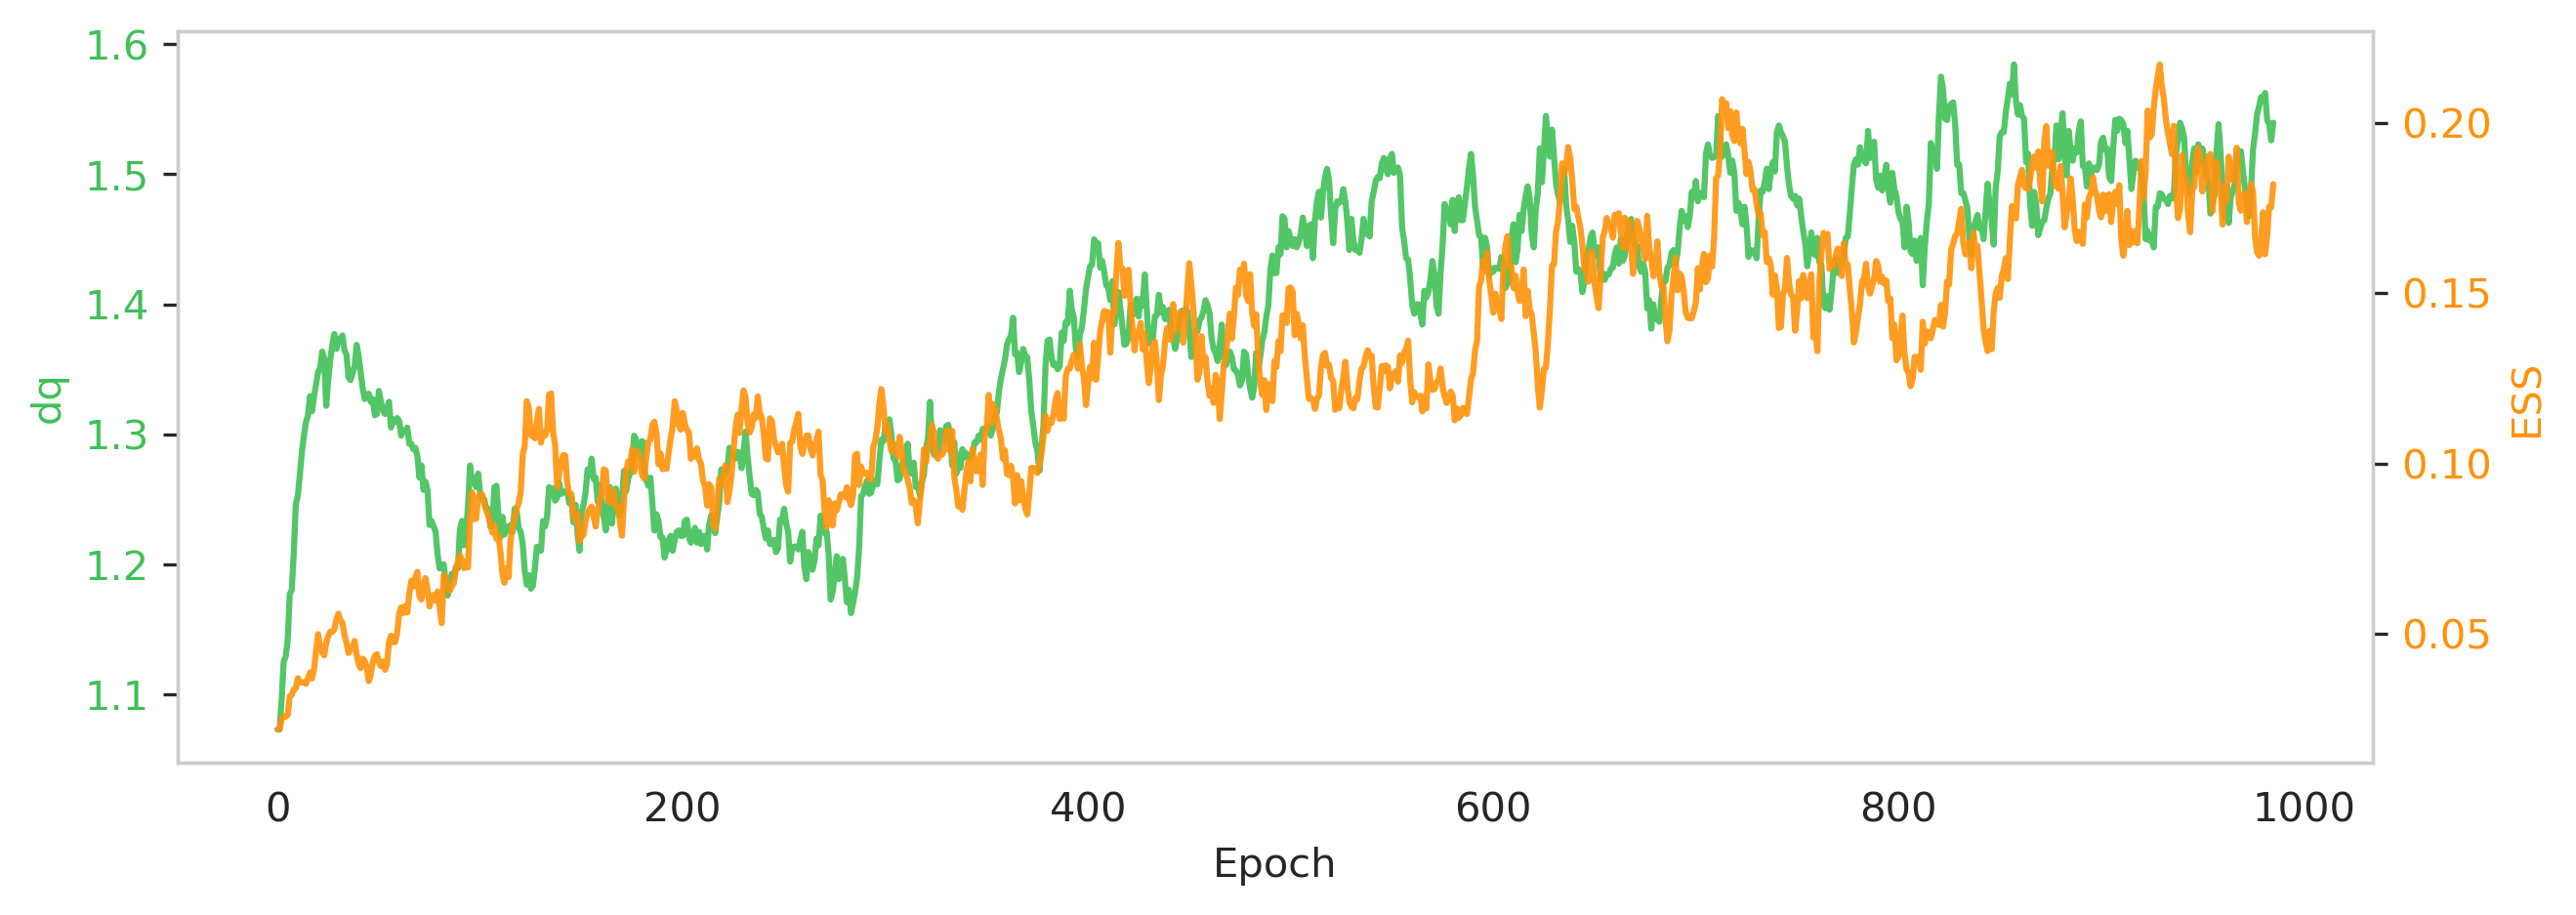

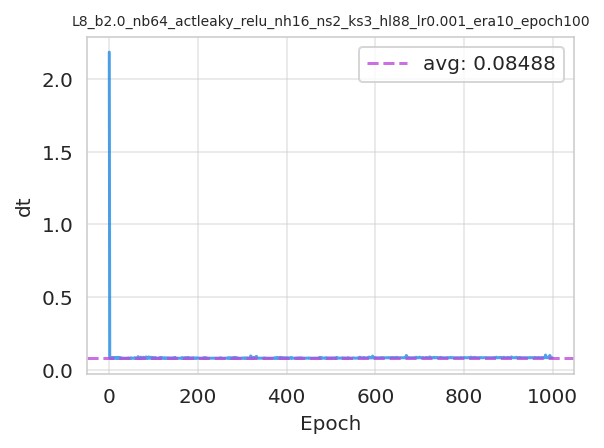

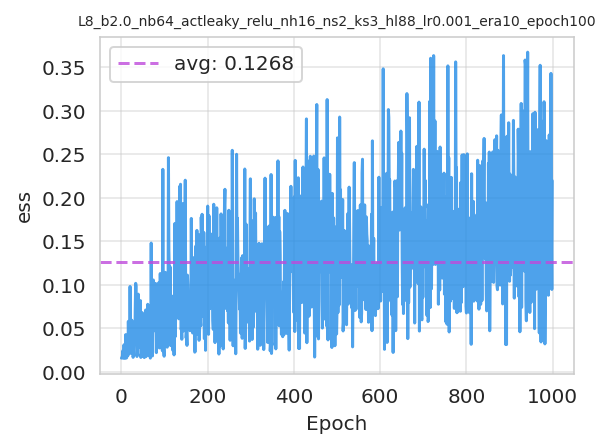

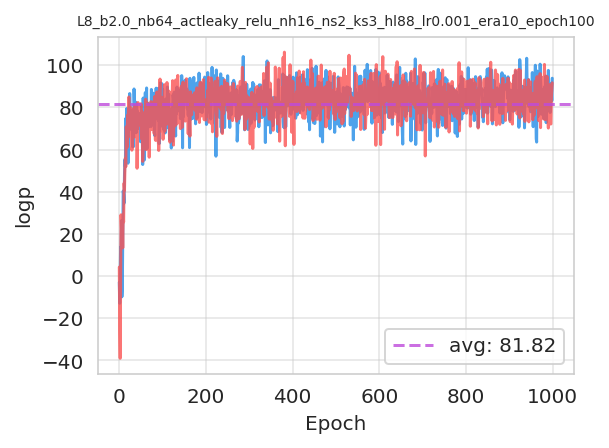

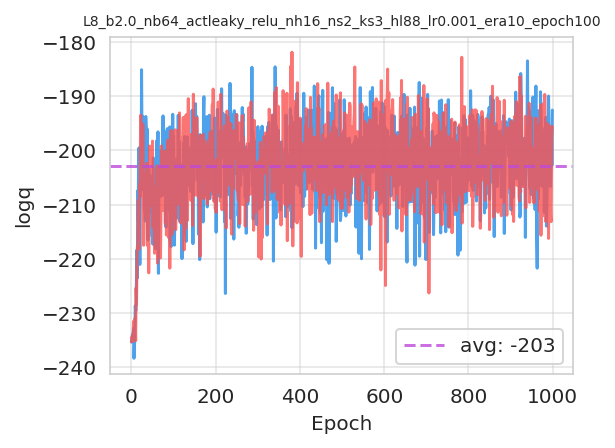

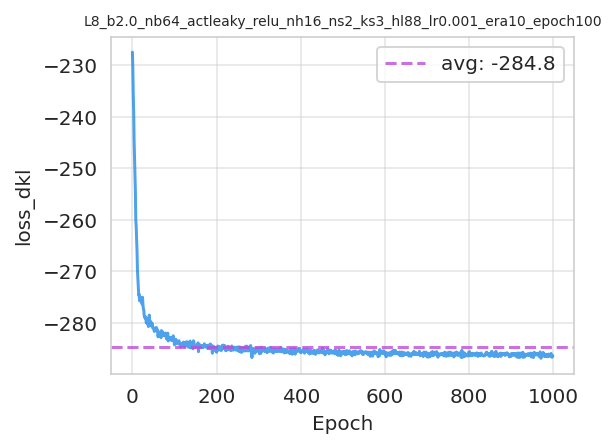

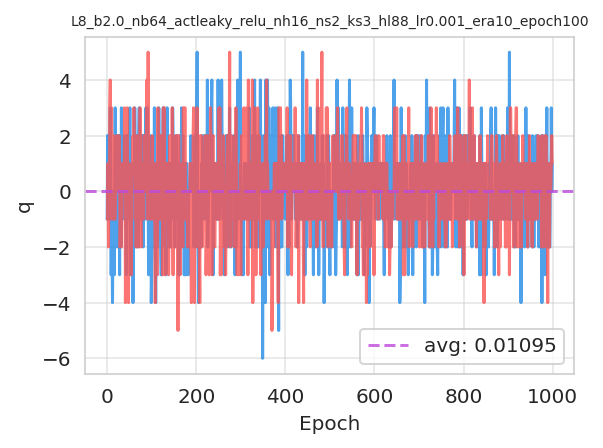

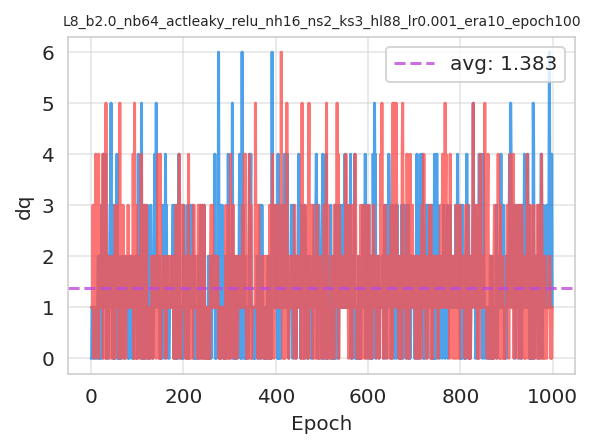

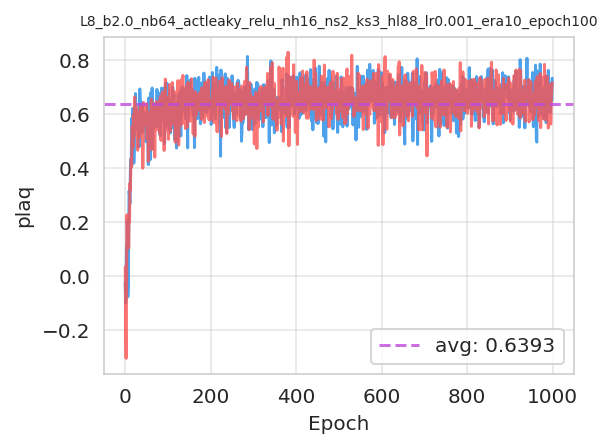

[17:24:10]  Saving train_history to ../../logs/models/lat8x8/beta2.0/L8_b2.0_nb64_actleaky_re
            lu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/training/2021-06-30-172222/train_hist
            ory.z.

In [4]:
from fthmc.train import train

logger.rule(f'Training FlowModel for {train_config.n_era} '
            f'eras and {train_config.n_epoch} epochs')
train_outputs = train(config=train_config,
                      model=None,  # train_outputs['model'],
                      pre_model=None,  # train_outputs['model'],
                      dpi=150,
                      figsize=(9, 3.),
                      scheduler_config=scheduler_config)

## Run inference on trained model and evaluate / plot metrics

──────────────────── Running inference on trained model for 8192 samples ────────────────────

/lus/grand/projects/DLHMC/nftqcd/fthmc/fthmc/utils/samplers.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(val)


[17:25:17]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/be
            ta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inferen
            ce/plots/q_172517.png

[17:25:17]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/
            plots/q_172517.png

            Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/be
            ta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inferen
            ce/plots/dqsq_172517.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/
            plots/dqsq_172517.png

[17:25:18]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/be
            ta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inferen
            ce/plots/logq_172518.png

[17:25:18]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/
            plots/logq_172518.png

            Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/be
            ta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inferen
            ce/plots/logp_172518.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/
            plots/logp_172518.png

            Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/be
            ta2.0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inferen
            ce/plots/acc_172518.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/
            plots/acc_172518.png

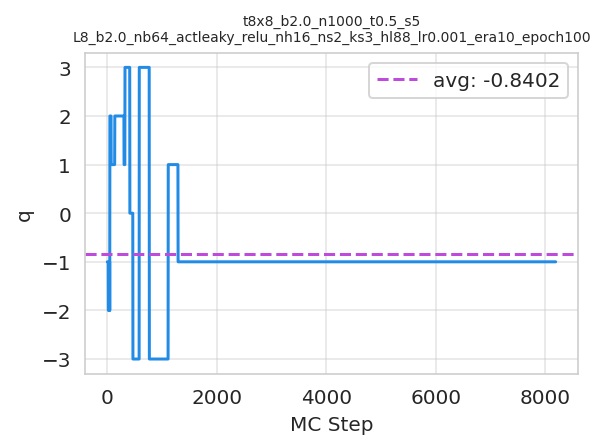

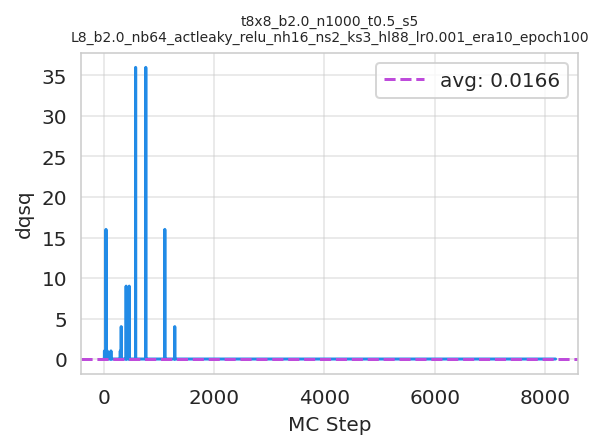

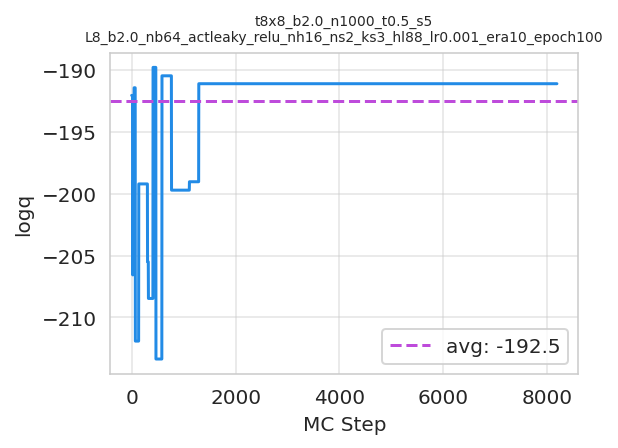

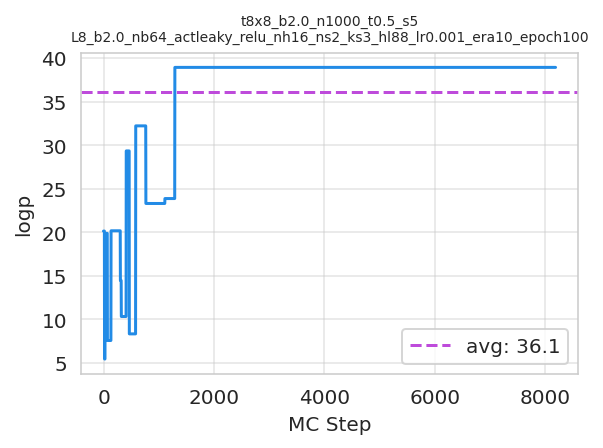

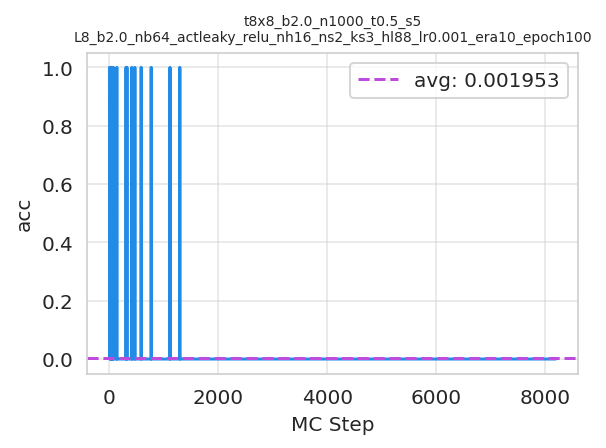

In [5]:
import fthmc.utils.qed_helpers as qed
from fthmc.utils.plot_helpers import plot_history
from fthmc.utils.samplers import make_mcmc_ensemble
from torch.utils.tensorboard import SummaryWriter

NUM_SAMPLES = 8192

logger.rule(f'Running inference on trained model for '
            f'{NUM_SAMPLES} samples')

action_fn = qed.BatchAction(train_config.beta)
logdir = train_config.logdir

inf_dir = os.path.join(logdir, 'inference')
inf_pdir = os.path.join(inf_dir, 'plots')
inf_sdir = os.path.join(inf_dir, 'summaries')

writer = SummaryWriter(log_dir=inf_sdir)

nb = train_config.batch_size
model = train_outputs['model']
history = make_mcmc_ensemble(model=model,
                             batch_size=nb, 
                             action_fn=action_fn,
                             num_samples=NUM_SAMPLES,
                             writer=writer)
plot_history(history=history,
             hline=True,
             param=param, config=train_config, skip=['epoch', 'x'],
             num_chains=4, therm_frac=0., xlabel='MC Step', outdir=inf_pdir)

[17:26:47]  slope 1 linear regression S = S_eff + -286.2718

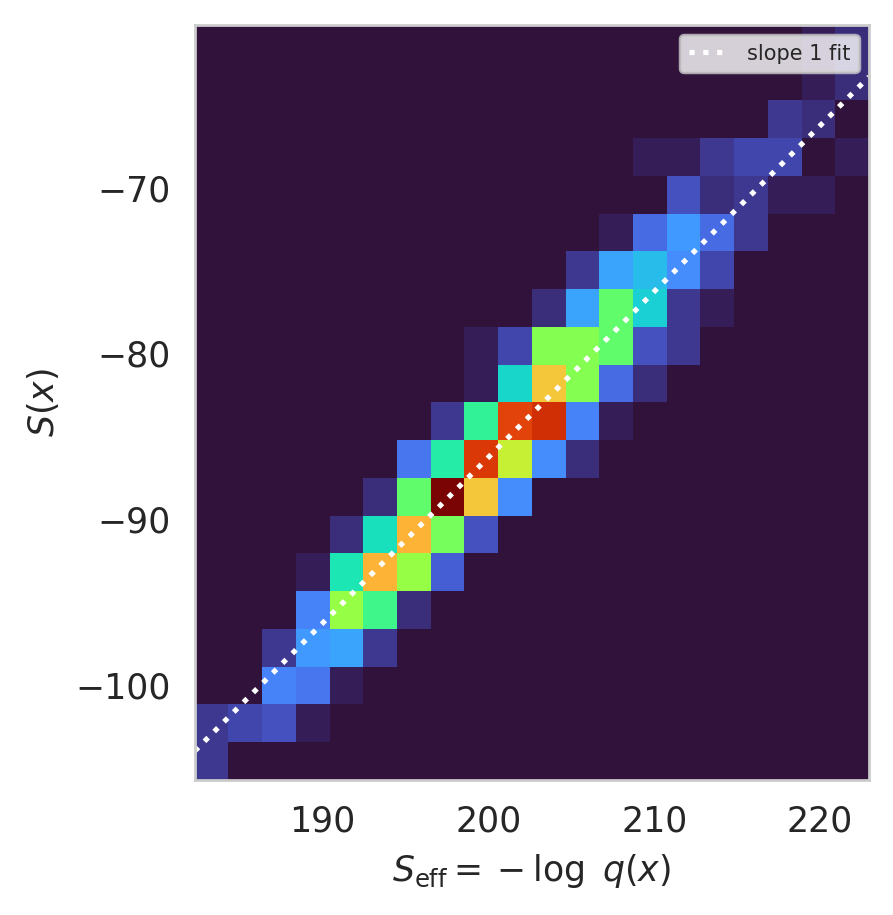

[17:26:48]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/models/lat8x8/beta2
            .0/L8_b2.0_nb64_actleaky_relu_nh16_ns2_ks3_hl88_lr0.001_era10_epoch100/inference/
            plots/action_linear_regression.pdf

<Figure size 432x288 with 0 Axes>

In [7]:
from fthmc.config import grab
import fthmc.utils.qed_helpers as qed
from fthmc.utils.samplers import apply_flow_to_prior


model = train_outputs['model']
prior = model.prior
layers = model.layers

action = qed.BatchAction(train_config.beta)

x_, xi_, logq_ = apply_flow_to_prior(prior,
                                     layers,
                                     batch_size=1024)
x = grab(x_)
S_eff = -grab(logq_)
S = grab(action(x_))
#S = grab(phi4_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)

logger.log(
    f'slope 1 linear regression S = S_eff + {fit_b:.4f}'
);

S_eff_lims = (np.min(S_eff), np.max(S_eff))
S_lims = (np.min(S), np.max(S))
axrange = [S_eff_lims, S_lims]

fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, cmap='turbo', range=axrange)

          #range=[[150, 195], [-230, -195]]);
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$');
ax.set_ylabel(r'$S(x)$');
ax.set_aspect('equal');
xs = np.linspace(np.min(S_eff), np.max(S_eff),
                 num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':',
        color='w', label='slope 1 fit');
plt.legend(prop={'size': 6});
plt.show();
outfile = os.path.join(inf_pdir,
                       'action_linear_regression.pdf')
logger.log(f'Saving figure to: {outfile}')
plt.savefig(outfile, dpi=250, bbox_inches='tight');

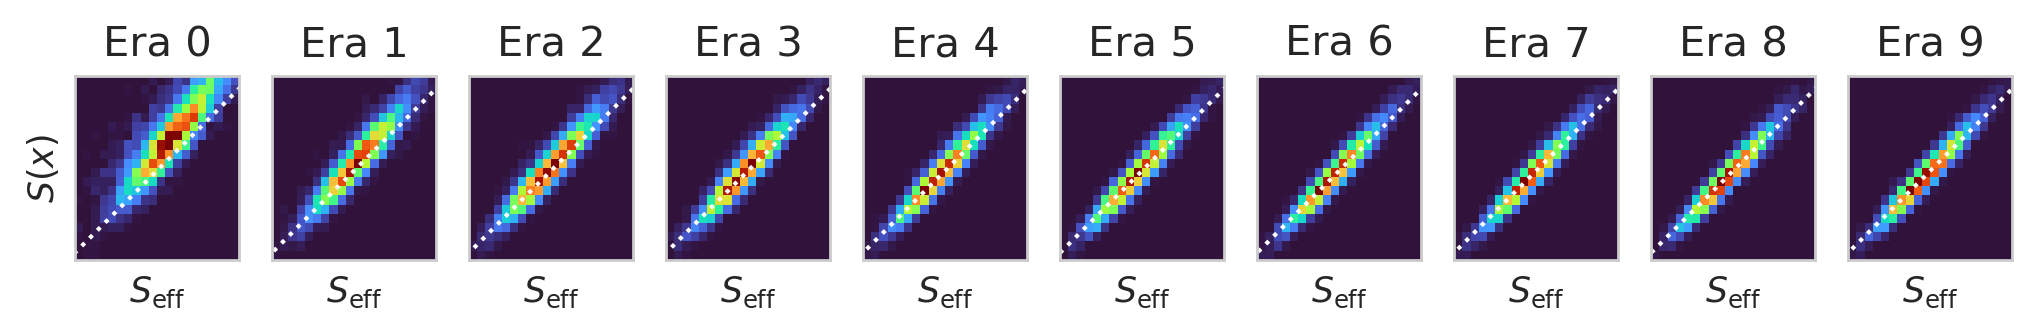

In [8]:
history = train_outputs['history']
n_era = train_config.n_era

fig, axes = plt.subplots(1, 10, dpi=125, sharey=True, figsize=(10, 1))

logq_hist = np.array(history['logq']).reshape(n_era, -1)[::n_era//10]
logp_hist = np.array(history['logp']).reshape(n_era, -1)[::n_era//10]

for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logp_hist)):
    ax.hist2d(-logq, -logp, bins=20, range=axrange, cmap='turbo');
    xs = np.linspace(np.min(-logq), np.max(-logq),
                     num=4, endpoint=True)
    ax.plot(xs, xs + fit_b, ':', lw=1.2,
            color='w', label='slope 1 fit');
    if i == 0:
        ax.set_ylabel(r'$S(x)$');
    ax.set_xlabel(r'$S_{\mathrm{eff}}$');
    ax.set_title(f'Era {i * (n_era//10)}');
    ax.set_xticks([]);
    ax.set_yticks([]);
    #ax.legend(prop={'size': 6});
    ax.set_aspect('equal');
plt.show();

## Run `FieldTransformation` HMC with trained model

In [9]:
import time
import torch.nn as nn

from fthmc.utils.plot_helpers import init_live_plot, update_plot
from math import pi as PI

TWO_PI = 2. * PI

───────────────────── Running HMC for 1 runs, each of 1000 trajectories ─────────────────────

[17:28:09]  Creating directory:                                                              
            ../../logs/hmc/lat8x8/beta2.0/t8x8_b2.0_n1000_t0.5_s5/2021-06-30-172809

[17:28:09]  Creating directory:                                                              
            ../../logs/hmc/lat8x8/beta2.0/t8x8_b2.0_n1000_t0.5_s5/2021-06-30-172809/plots

[17:28:09]  Param:                                                                           
            ----------------                                                                 
            beta=2.0                                                                         
            L=8                                                                              
            tau=0.5                                                                          
            nstep=5                                                                          
            ntraj=1000                                                                       
            nrun=1                                                                           
            nprint=100                                                                       
            seed=1331                                                                        
            randinit=False                                                                   
            nth_interop=2                                                                    
            nth=2                                                                            
            lat=[8, 8]                                                                       
            nd=2                                                                             
            shape=[2, 8, 8]                                                                  
            volume=64                                                                        
            dt=0.1                                                                           
            logdir=/lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/t8x8_b2.0_n
            1000_t0.5_s5

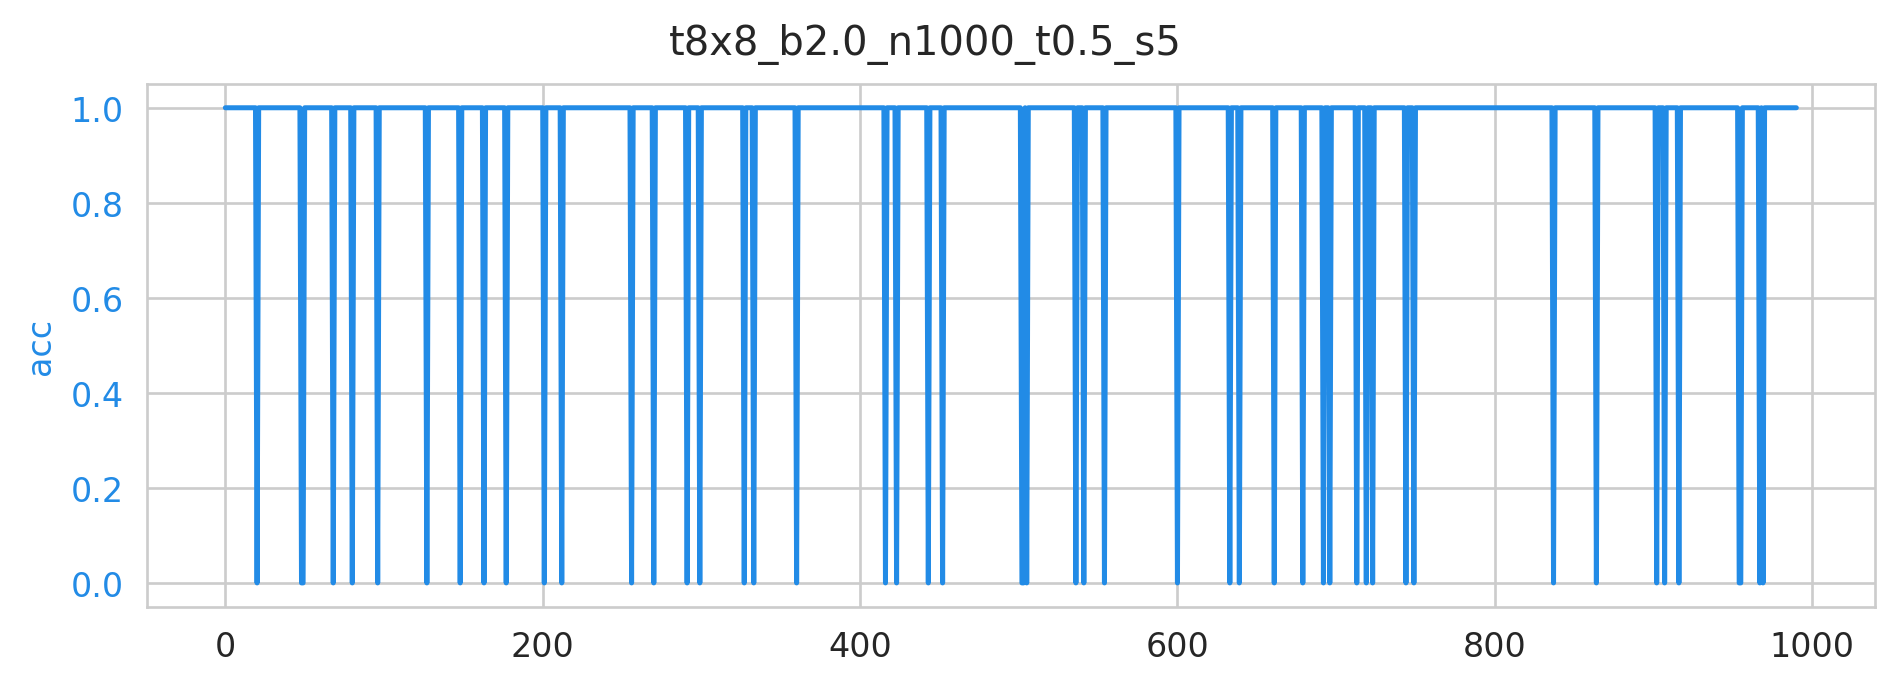

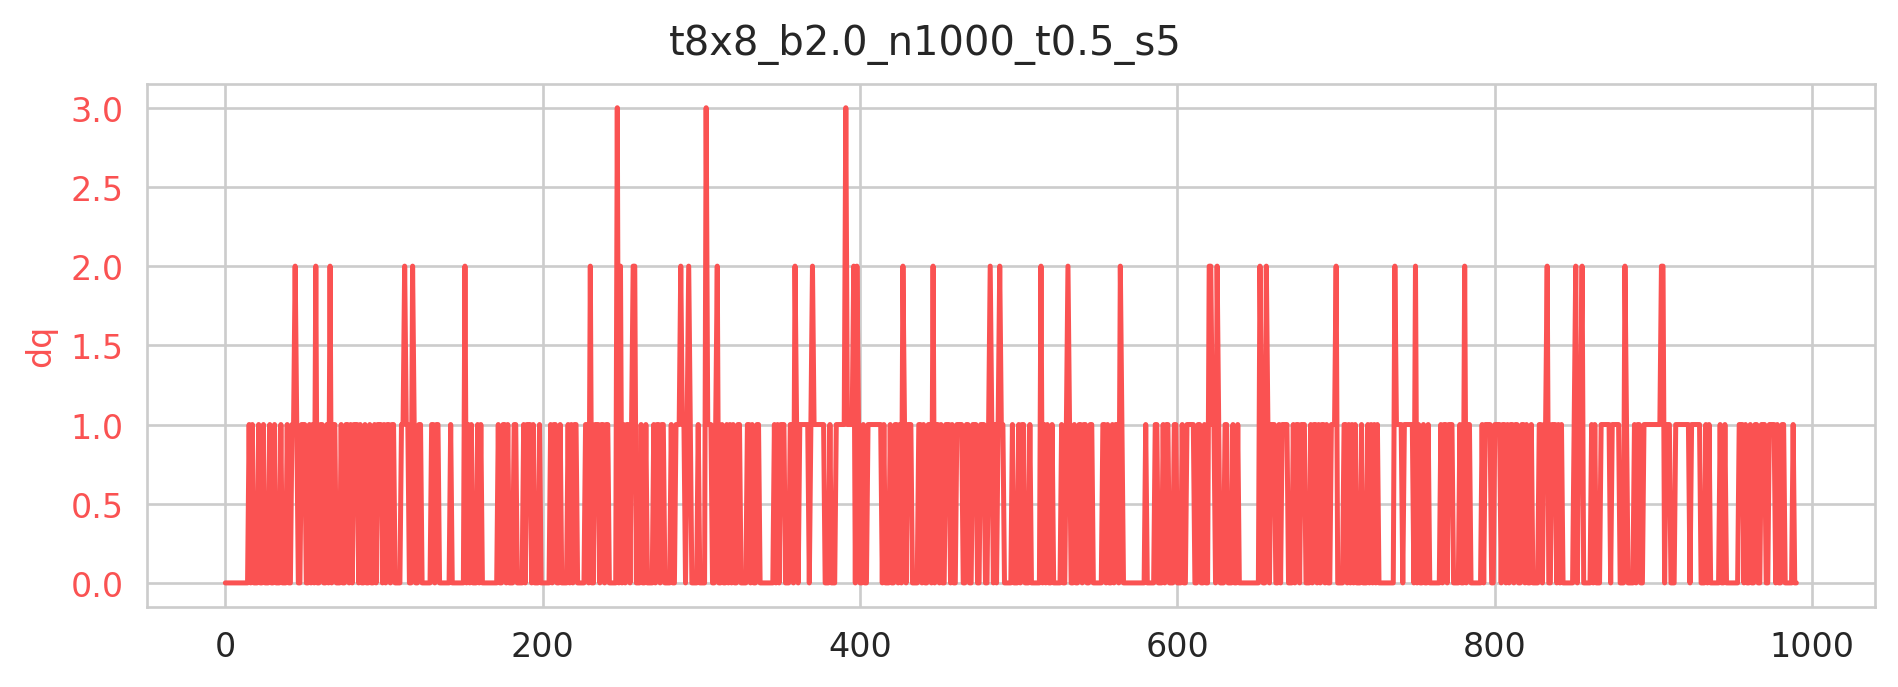

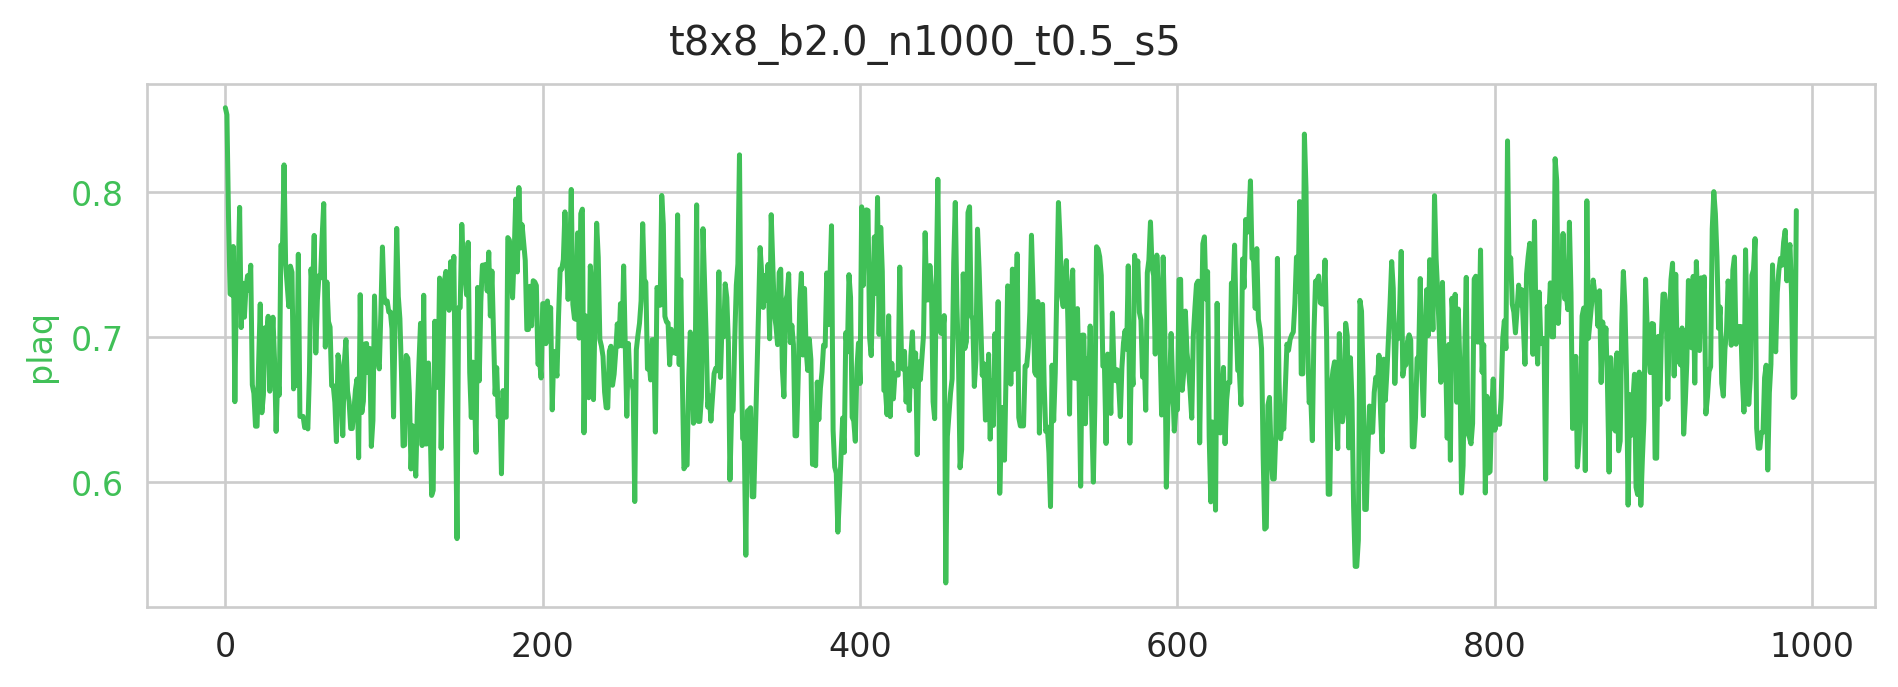

──────────────────────────────── RUN: 0, last took: 0 m 0 s ─────────────────────────────────

[17:28:10]  plaq=1.000 q=0.000

            traj=2 dt=0.004 acc=1.000 dH=0.011 plaq=0.853 q=0 dq=0.000

[17:28:17]  traj=102 dt=0.004 acc=1.000 dH=-0.008 plaq=0.723 q=0 dq=0.000

[17:28:24]  traj=202 dt=0.004 acc=0.000 dH=0.104 plaq=0.723 q=0 dq=0.000

[17:28:30]  traj=302 dt=0.004 acc=1.000 dH=0.079 plaq=0.774 q=1 dq=0.000

[17:28:37]  traj=402 dt=0.004 acc=1.000 dH=0.251 plaq=0.790 q=1 dq=0.000

[17:28:43]  traj=502 dt=0.004 acc=1.000 dH=-0.043 plaq=0.638 q=0 dq=0.000

[17:28:50]  traj=602 dt=0.004 acc=1.000 dH=0.194 plaq=0.739 q=0 dq=0.000

[17:28:57]  traj=702 dt=0.004 acc=1.000 dH=-0.069 plaq=0.623 q=0 dq=0.000

[17:29:04]  traj=802 dt=0.004 acc=1.000 dH=-0.006 plaq=0.641 q=0 dq=1.000

[17:29:11]  traj=902 dt=0.004 acc=1.000 dH=-0.236 plaq=0.616 q=0 dq=1.000

[17:29:17]  Creating directory: ../../logs/hmc/lat8x8/beta2.0/t8x8_b2.0_n1000_t0.5_s5/2021-06
            -30-172809/plots/run0

[17:29:17]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-06-30-172809/plots/run0/traj.png

[17:29:18]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-06-30-172809/plots/run0/dt.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-06-30-172809/plots/run0/acc.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-06-30-172809/plots/run0/dH.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-06-30-172809/plots/run0/plaq.png

[17:29:19]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-06-30-172809/plots/run0/q.png

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/hmc/lat8x8/beta2.0/
            t8x8_b2.0_n1000_t0.5_s5/2021-06-30-172809/plots/run0/dq.png

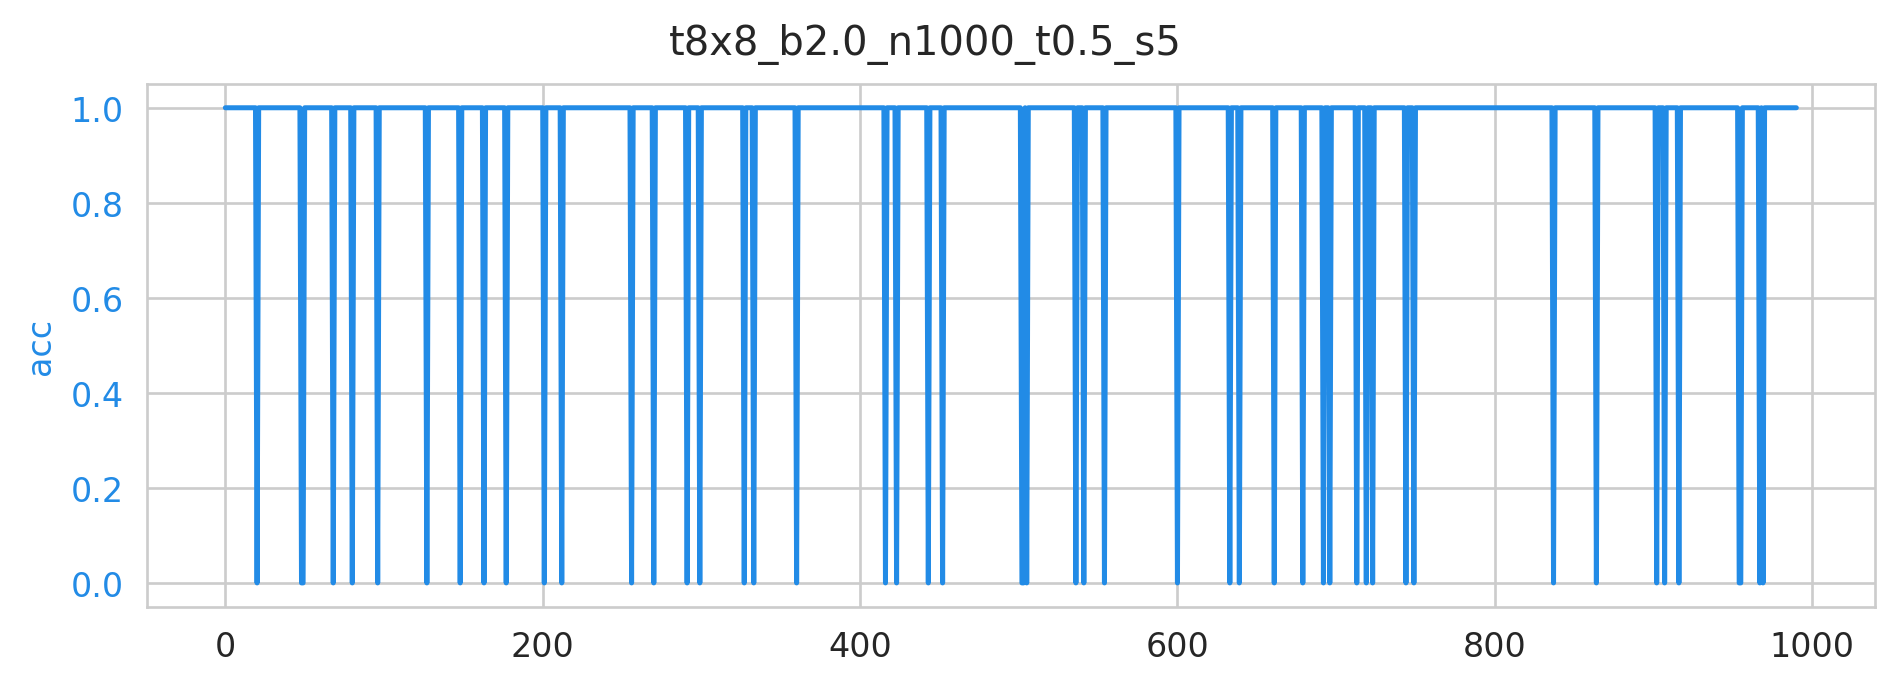

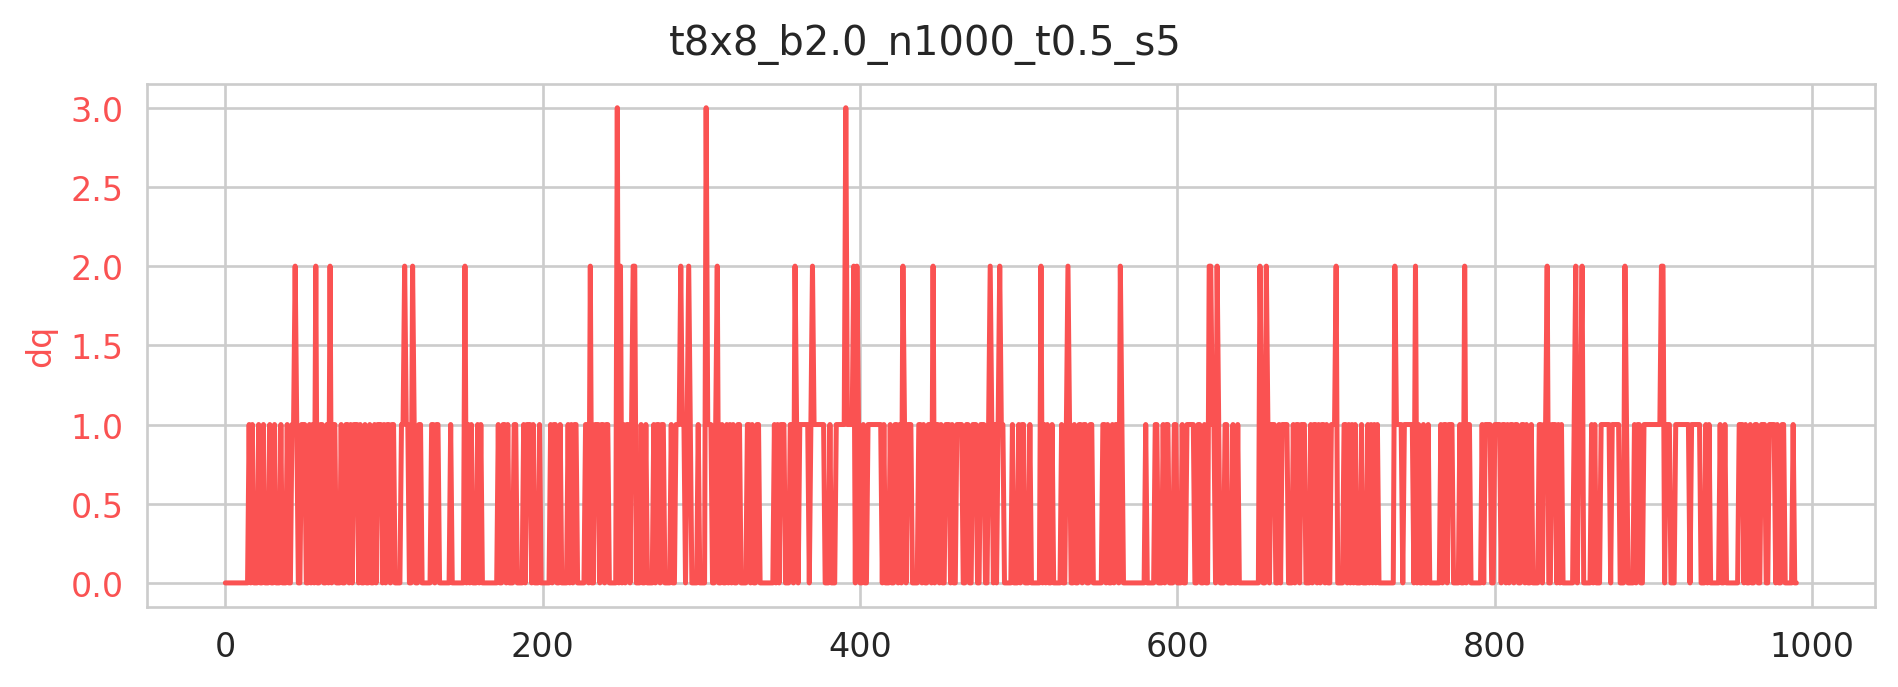

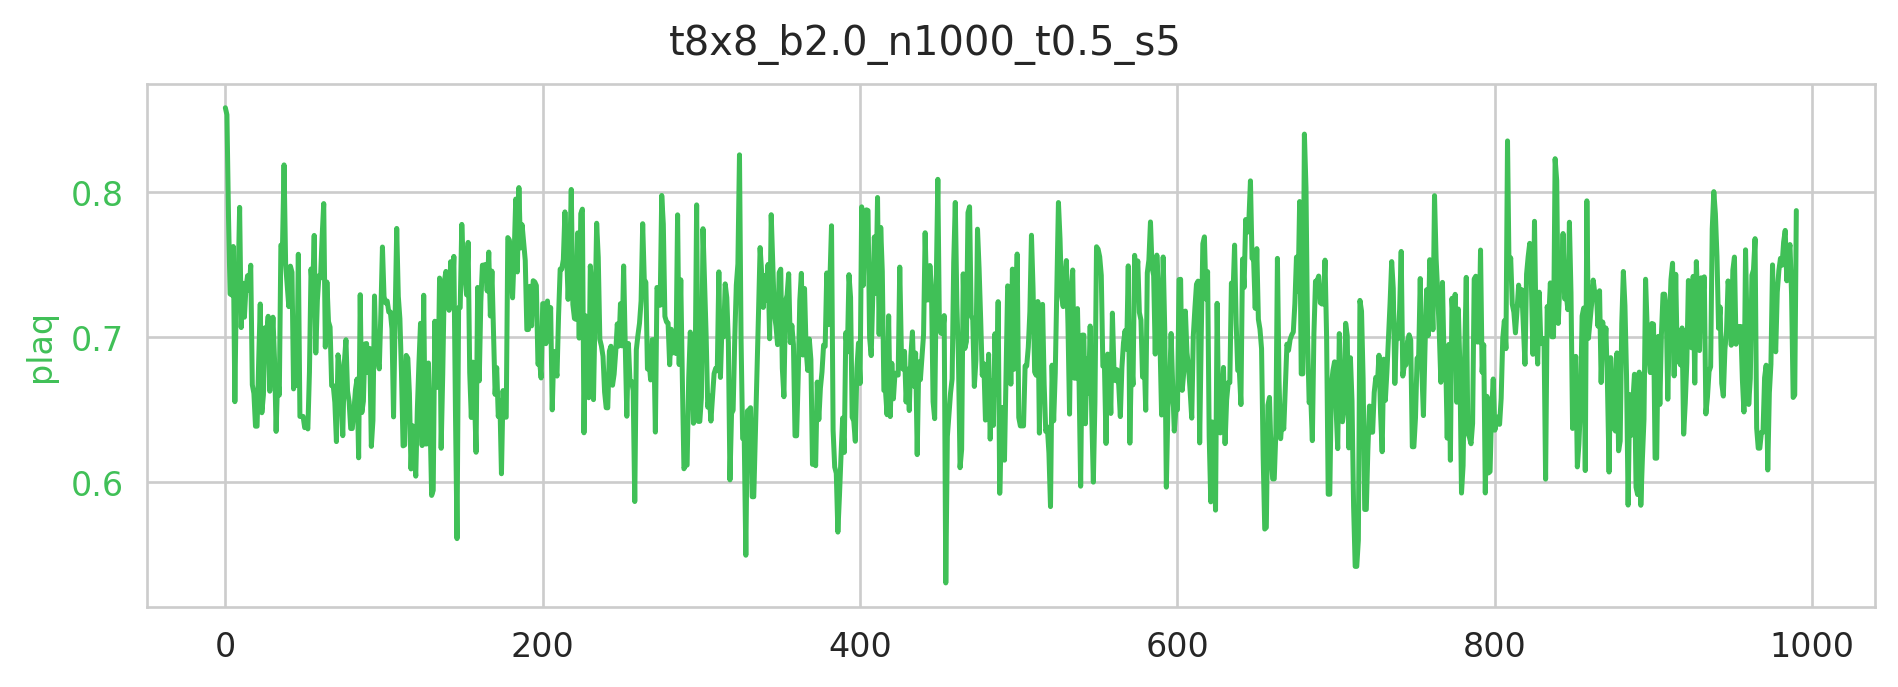

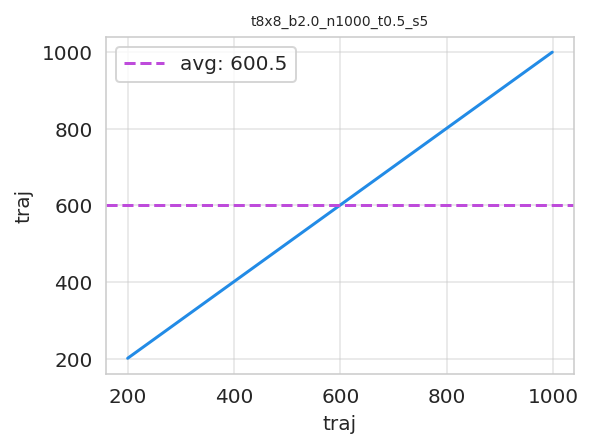

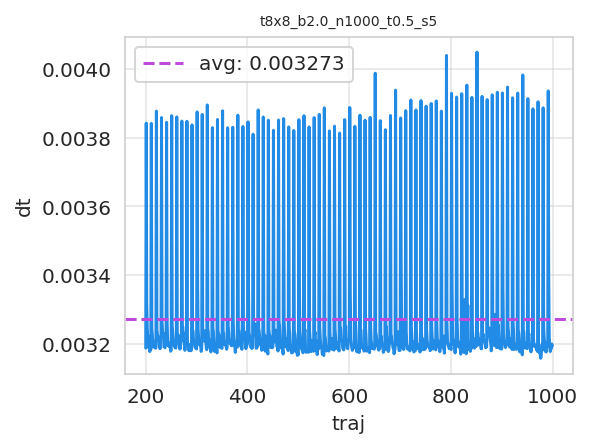

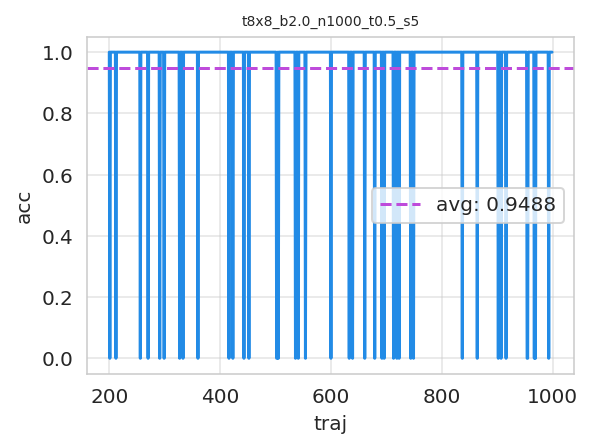

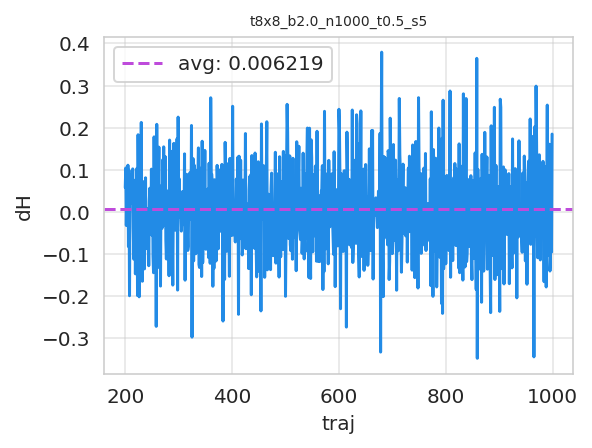

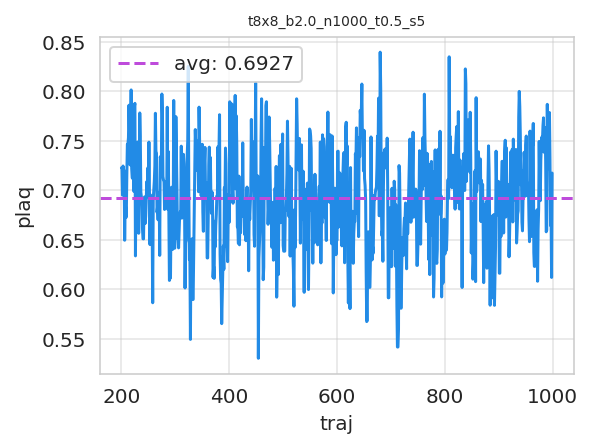

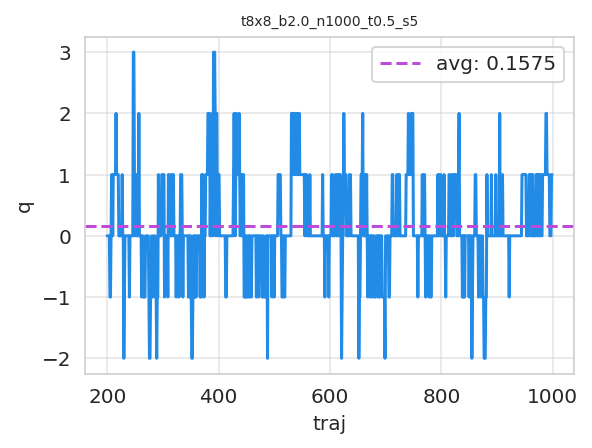

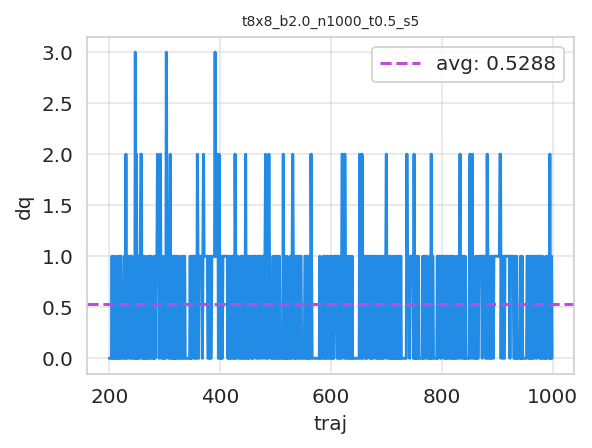

[17:29:21]  Run times: ['67.3612']

            Per trajectory: ['0.0674']

[17:29:21]  Saving hmc_histories to ../../logs/hmc/lat8x8/beta2.0/t8x8_b2.0_n1000_t0.5_s5/202
            1-06-30-172809/hmc_histories.z.

[17:29:21]  Saving hmc_fields_arr to ../../logs/hmc/lat8x8/beta2.0/t8x8_b2.0_n1000_t0.5_s5/20
            21-06-30-172809/hmc_fields_arr.z.

In [10]:
from fthmc.main import hmc
hmc_outputs = hmc(param)

In [11]:
from dataclasses import asdict
from fthmc.utils.plot_helpers import update_plot
from fthmc.field_transformation import FieldTransformation
from fthmc.config import ftConfig

ftconfig = ftConfig(tau=param.tau, nstep=param.nstep) 

flow = train_outputs['model'].layers
    
if torch.cuda.is_available():
    flow.to('cuda')
    
flow.eval()
#pdict = asdict(param)
#pdict['tau'] = 0.1
#pdict['nstep'] = 5


field_transformation = FieldTransformation(flow=flow, config=train_config, ftconfig=ftconfig)

ModuleList(
  (0): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      )
    )
  )
  (1): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circ

ModuleList(
  (0): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      )
    )
  )
  (1): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circ

[17:33:30]  plaq=0.399 q=-4.000

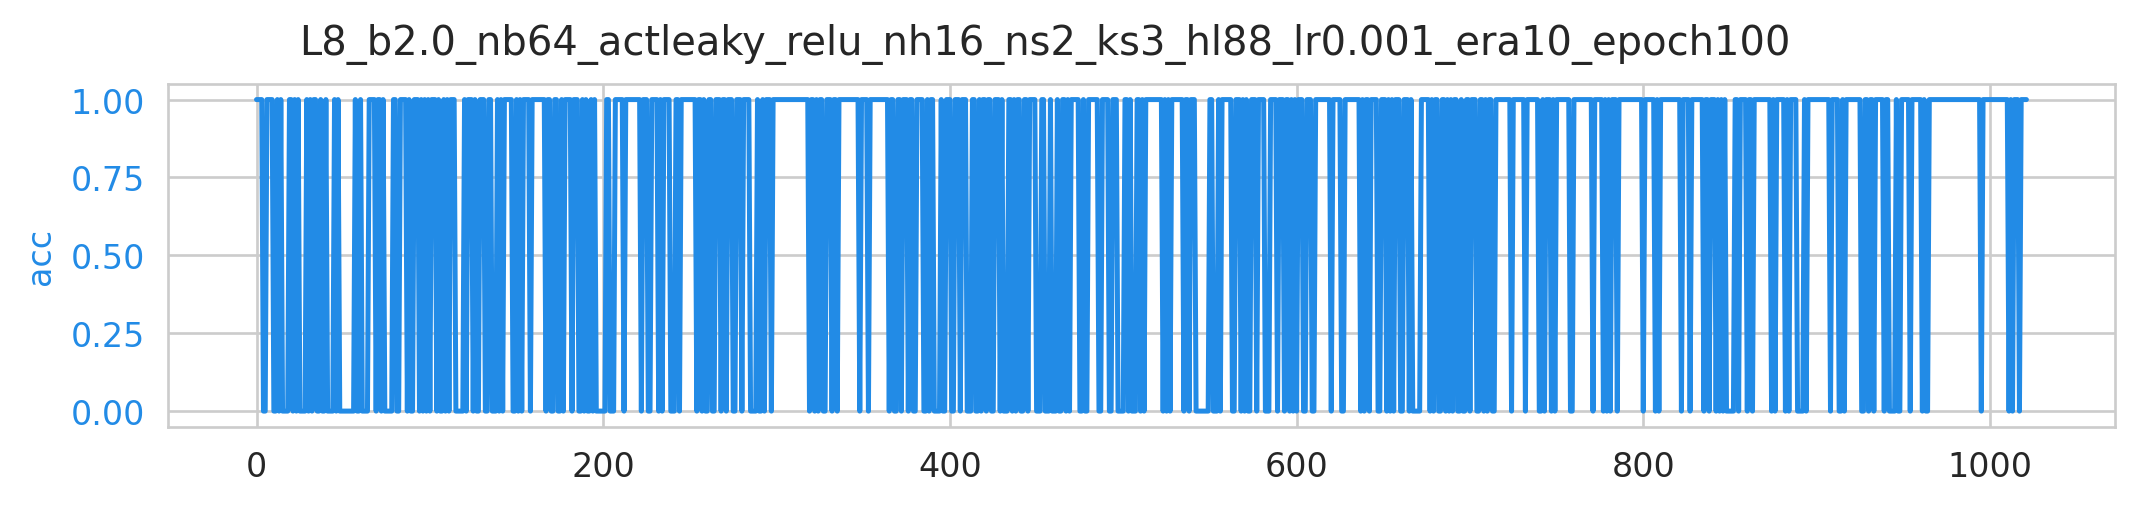

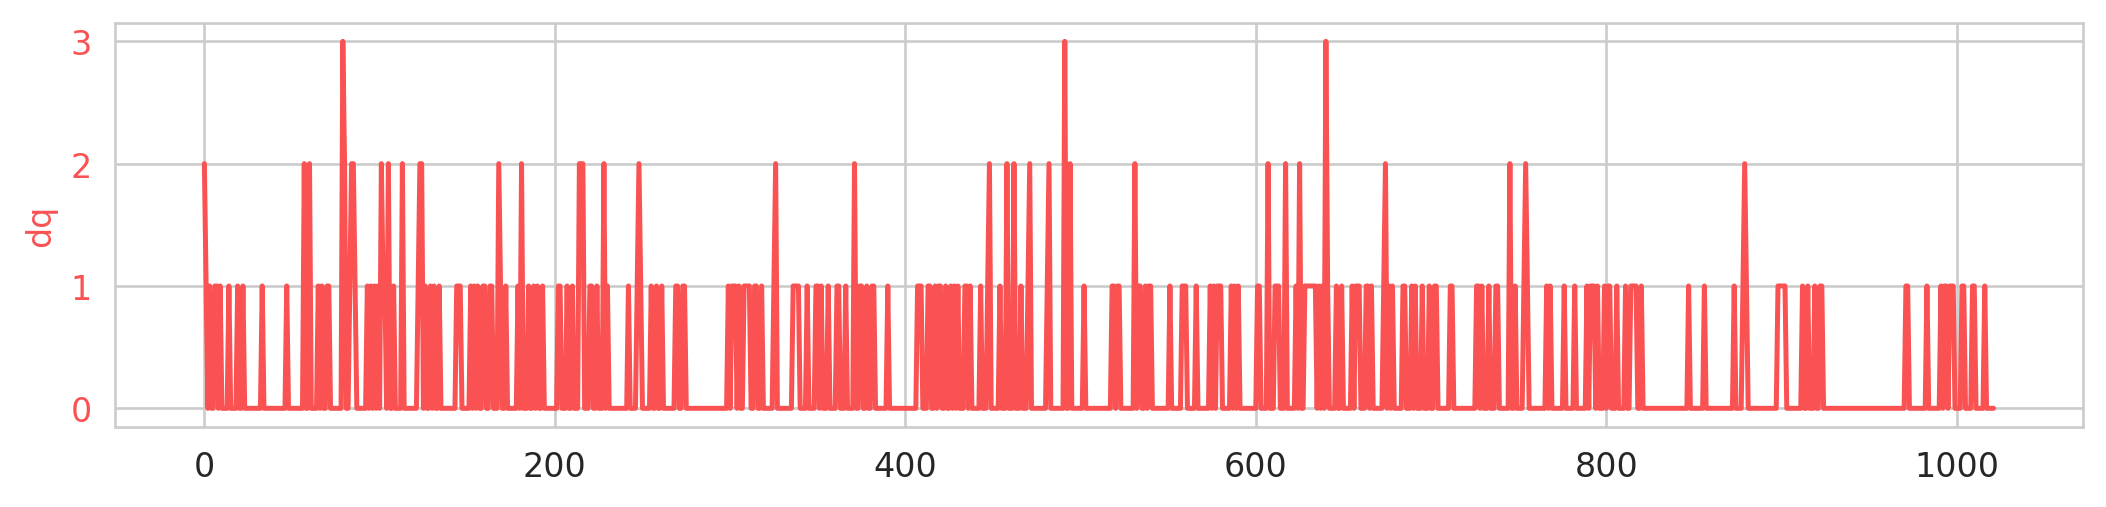

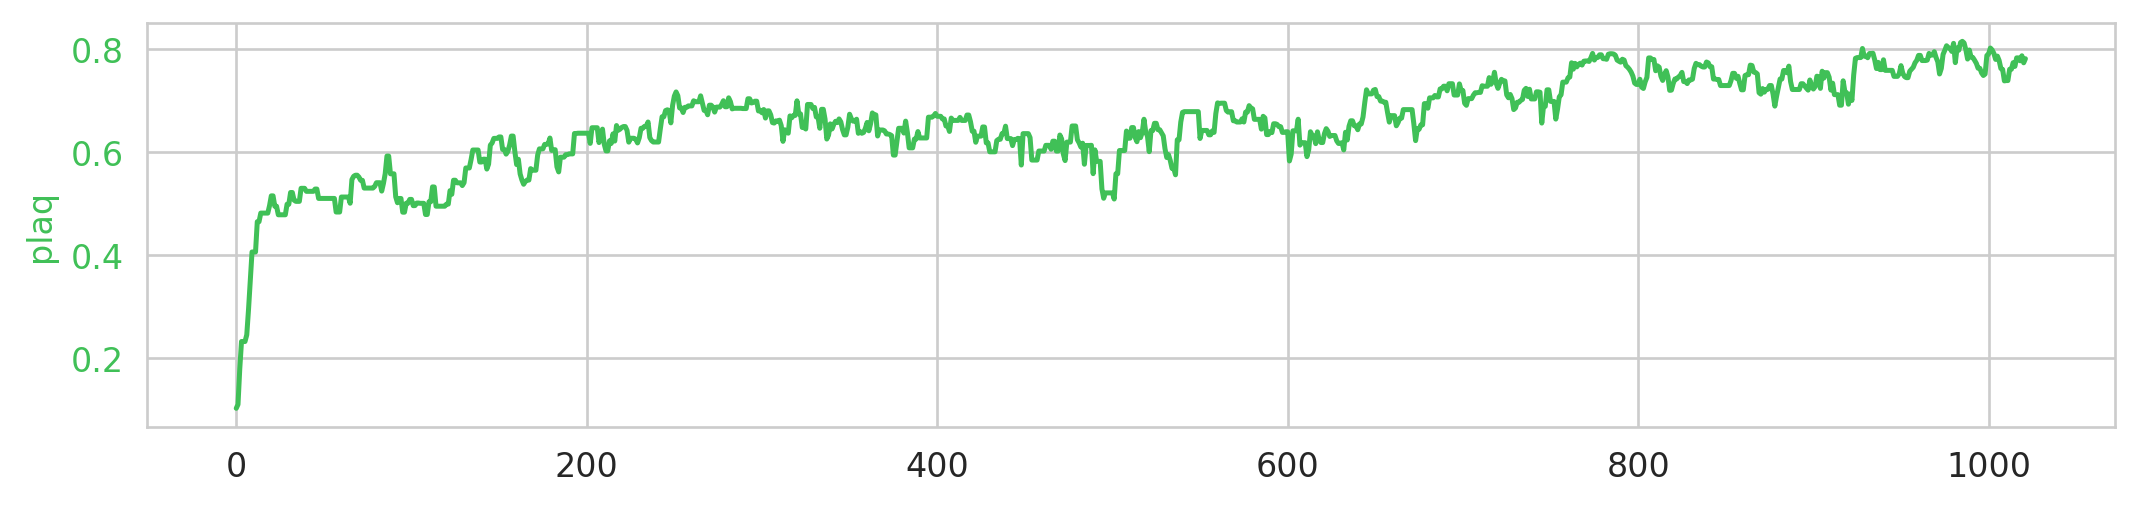

/lus/grand/projects/DLHMC/nftqcd/fthmc/fthmc/field_transformation.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val = torch.tensor(val, dtype=DTYPE)


[17:33:31]  traj=0 dt=0.718 acc=1.000 dh=-2.341 plaq=0.103 q=-2.000 dq=2.000

[17:34:09]  traj=50 dt=0.619 acc=0.000 dh=3.381 plaq=0.510 q=-2.000 dq=0.000

[17:34:46]  traj=100 dt=0.612 acc=0.000 dh=0.776 plaq=0.508 q=-1.000 dq=0.000

[17:35:24]  traj=150 dt=0.608 acc=1.000 dh=-0.241 plaq=0.629 q=-2.000 dq=0.000

[17:36:03]  traj=200 dt=0.607 acc=0.000 dh=0.615 plaq=0.636 q=0.000 dq=0.000

[17:36:39]  traj=250 dt=0.610 acc=1.000 dh=-0.228 plaq=0.708 q=-1.000 dq=0.000

[17:37:16]  traj=300 dt=0.610 acc=1.000 dh=0.855 plaq=0.676 q=-1.000 dq=0.000

[17:37:54]  traj=350 dt=0.618 acc=1.000 dh=0.061 plaq=0.673 q=0.000 dq=1.000

[17:38:32]  traj=400 dt=0.634 acc=1.000 dh=-0.095 plaq=0.669 q=-1.000 dq=0.000

[17:39:11]  traj=450 dt=0.642 acc=0.000 dh=5.171 plaq=0.636 q=0.000 dq=0.000

[17:39:49]  traj=500 dt=0.691 acc=0.000 dh=1.334 plaq=0.521 q=1.000 dq=0.000

[17:40:28]  traj=550 dt=0.638 acc=1.000 dh=0.790 plaq=0.626 q=1.000 dq=0.000

[17:41:06]  traj=600 dt=0.614 acc=0.000 dh=1.068 plaq=0.639 q=2.000 dq=0.000

[17:41:44]  traj=650 dt=0.616 acc=1.000 dh=-0.481 plaq=0.721 q=-1.000 dq=0.000

[17:42:22]  traj=700 dt=0.610 acc=0.000 dh=1.137 plaq=0.719 q=1.000 dq=0.000

[17:43:00]  traj=750 dt=0.633 acc=1.000 dh=-0.896 plaq=0.698 q=-0.000 dq=0.000

[17:43:39]  traj=800 dt=0.631 acc=0.000 dh=0.375 plaq=0.731 q=0.000 dq=0.000

[17:44:18]  traj=850 dt=0.629 acc=0.000 dh=1.600 plaq=0.729 q=0.000 dq=0.000

[17:44:57]  traj=900 dt=0.667 acc=1.000 dh=0.307 plaq=0.722 q=1.000 dq=1.000

[17:45:35]  traj=950 dt=0.611 acc=1.000 dh=0.367 plaq=0.767 q=-0.000 dq=0.000

[17:46:13]  traj=1000 dt=0.876 acc=1.000 dh=-0.021 plaq=0.790 q=-1.000 dq=0.000

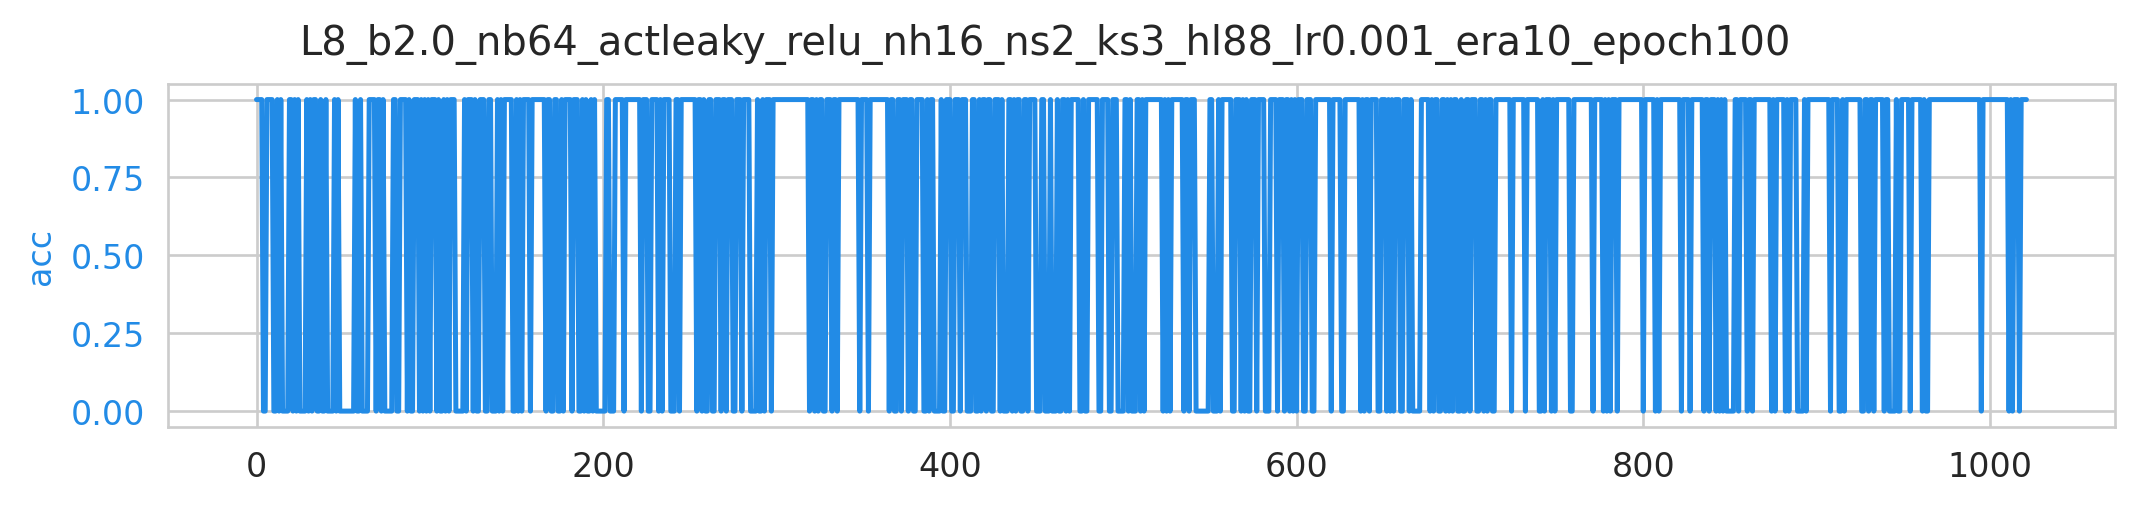

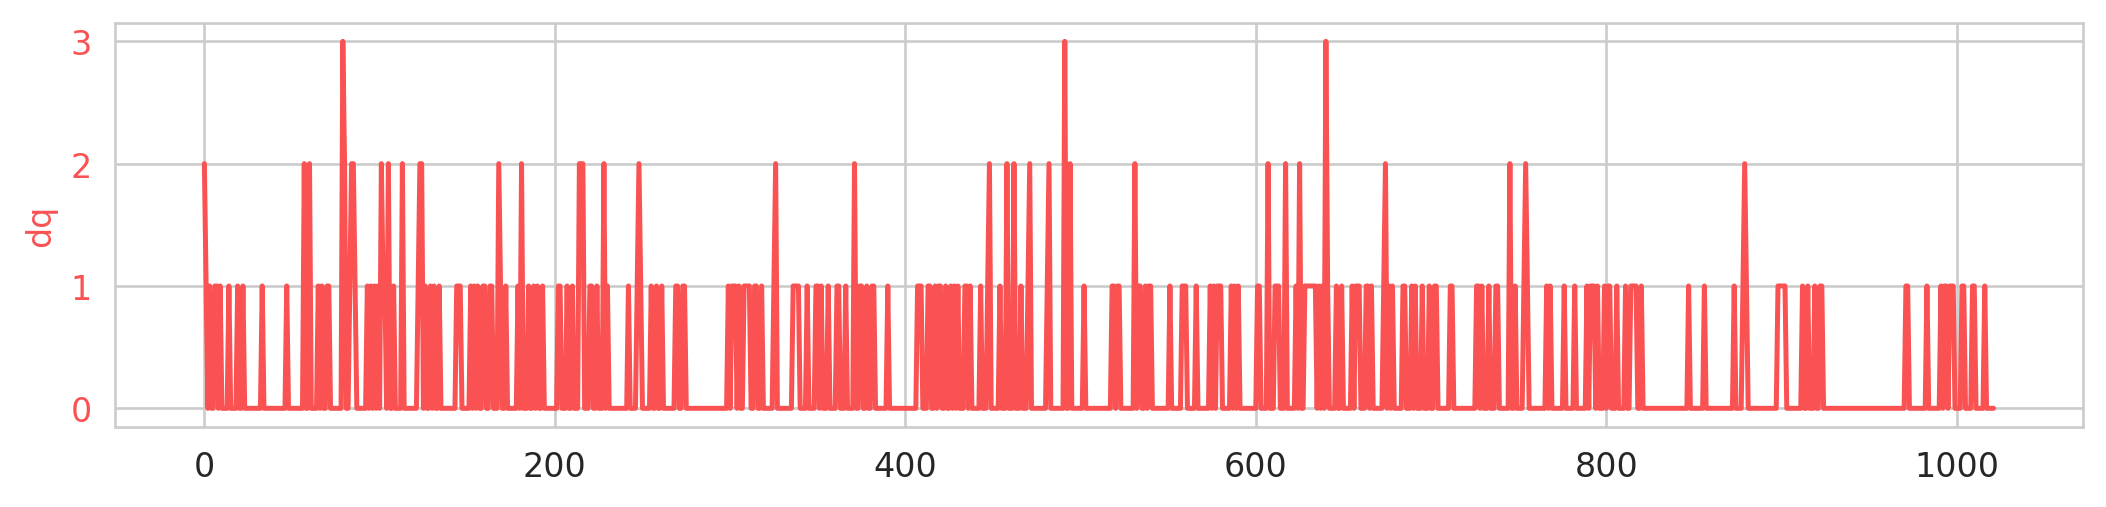

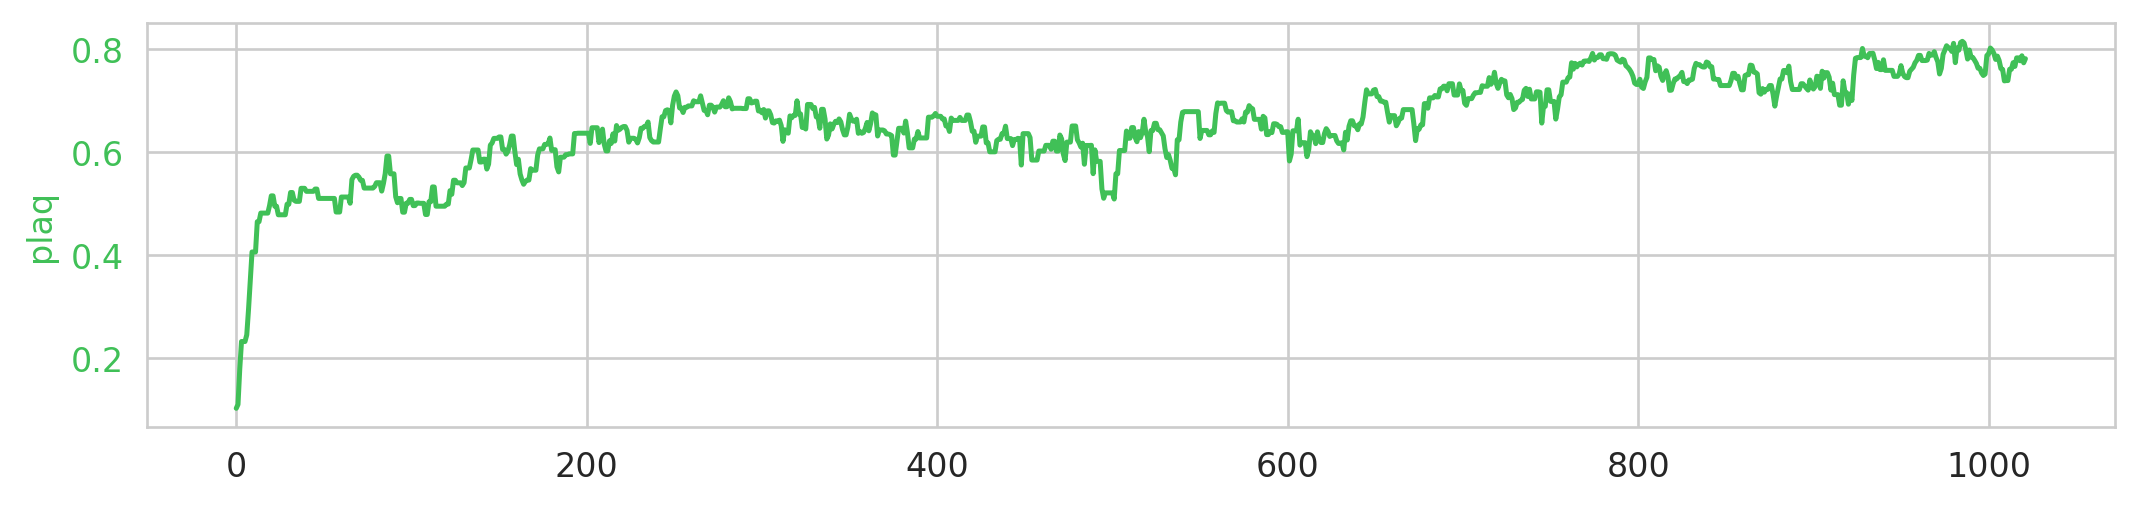

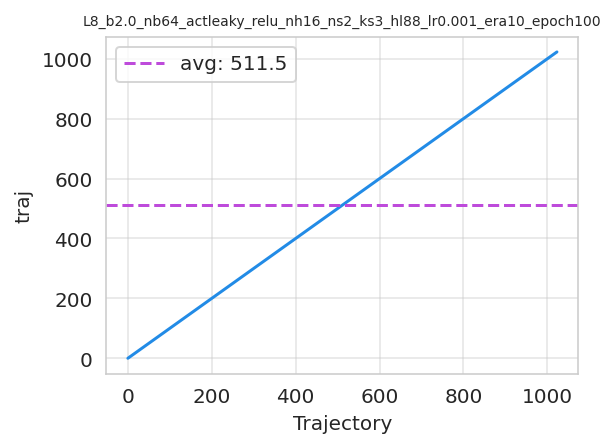

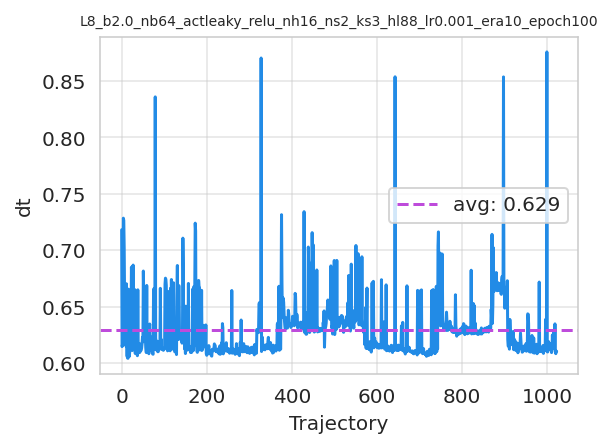

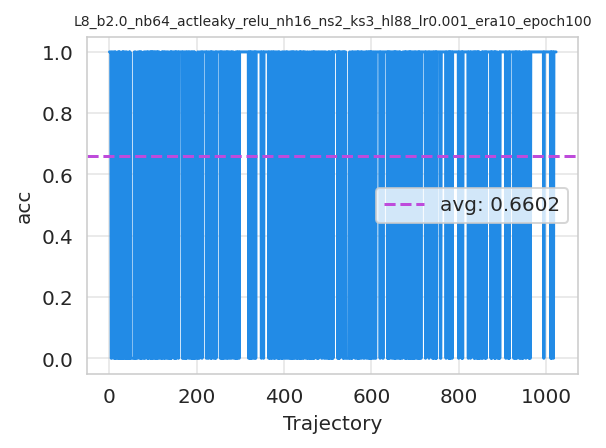

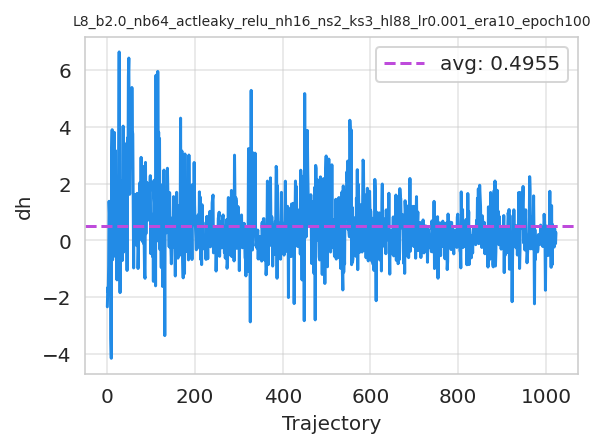

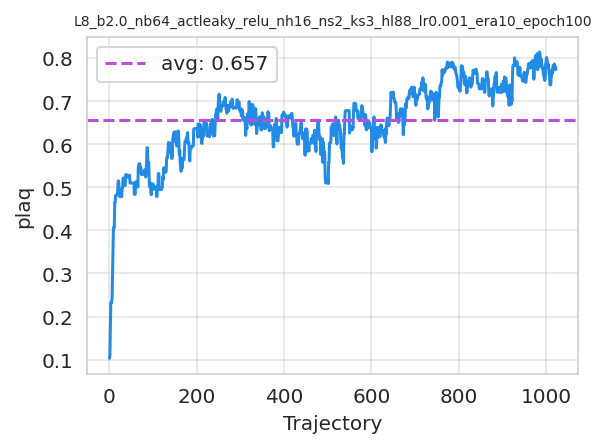

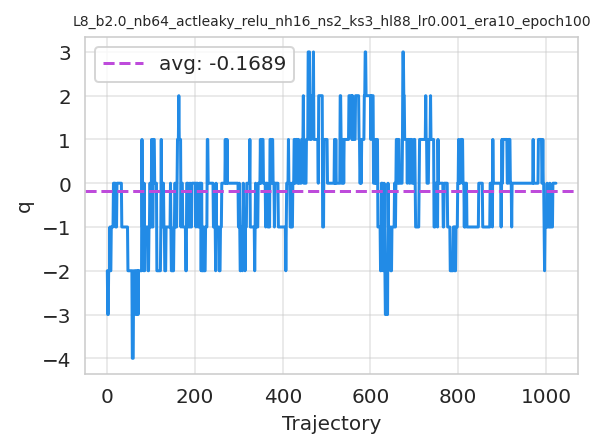

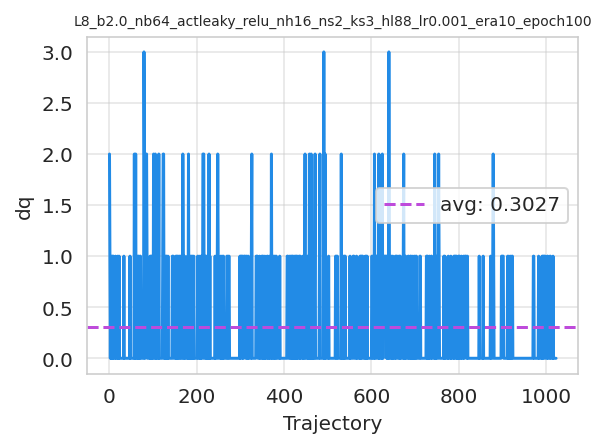

In [12]:
#x_ = hmc_fields[-1][-1].cuda()

logdir = train_config.logdir

ftstr = ftconfig.uniquestr()
fthmcdir = os.path.join(logdir, 'ftHMC', ftstr)

pdir = os.path.join(fthmcdir, 'plots')
sdir = os.path.join(fthmcdir, 'summaries')

writer = SummaryWriter(log_dir=sdir)

runs_history = field_transformation.run(nprint=50,
                                        #x=x_,
                                        figsize=(9., 2.),
                                        num_trajs=1024,
                                        writer=writer,
                                        dpi=120, nplot=5, window=1)

#  Transfer to larger lattice


In [ ]:
from dataclasses import asdict
from fthmc.train import train, transfer_to_new_lattice

from torch import nn 

def transfer(
        L: int,
        param: Param,
        config: TrainConfig,
        scheduler_config: SchedulerConfig,
        layers: nn.ModuleList,
        new_lr: float = None,
        run_hmc: bool = True,
        figsize: tuple = None,
):
    if figsize is None:
        figsize = (9, 2)
        
    xfr = transfer_to_new_lattice(L=L,
                                  layers=layers,
                                  param_init=param)
    param_new = xfr['param']
    model_new = xfr['model']
    # ----------------------------------------------
    # Run HMC using new (transferred) `param` above
    # ----------------------------------------------
    if run_hmc:
        from fthmc.hmc import run_hmc
        hmc_fields, hmc_history = run_hmc(param_new)


    if new_lr is not None:
        cfg_dict = asdict(config)
        cfg_dict['base_lr'] = new_lr
        config_new = TrainConfig(**cfg_dict)
    else:
        config_new = config

    train_outputs = train(config_new,
                          model=model_new,
                          pre_model=None,
                          figsize=figsize,
                          scheduler_config=scheduler_config)
    return {
        'param': param_new,
        'config': config_new,
        'model': model_new,
        'outputs': train_outputs
    }

In [ ]:
layers8 = train_outputs['model'].layers #['layers']
layers8.train()
train_outputs16 = transfer(L=16, param=param,
                           config=train_config,
                           layers=layers8, 
                           scheduler_config=scheduler_config,
                           new_lr=0.0001, run_hmc=True)

## Run inference on trained model

In [ ]:
param16 = train_outputs16['param']
config16 = train_outputs16['config']
model16 = train_outputs16['model']
outputs16 = train_outputs16['outputs']

In [ ]:
action_fn16 = qed.BatchAction(param16.beta)

history16 = make_mcmc_ensemble(model=model16,
                               action_fn=action_fn16,
                               batch_size=config16.batch_size,
                               num_samples=8192)
plot_history(history=history16,
             param=param16, config=config16, skip=['epoch', 'x'],
             num_chains=4, therm_frac=0.0, xlabel='MC Step')#, outdir=inf_pdir8)

## Run `ftHMC` on trained model

In [ ]:
from dataclasses import asdict
from fthmc.utils.plot_helpers import update_plot
from fthmc.field_transformation import FieldTransformation
from fthmc.config import ftConfig

ftconfig16 = ftConfig(tau=0.05, nstep=2) 

flow16 = train_outputs16['model'].layers
    
if torch.cuda.is_available():
    flow16.to('cuda')
    
flow16.eval()
#pdict = asdict(param)
#pdict['tau'] = 0.1
#pdict['nstep'] = 5


field_transformation16 = FieldTransformation(flow=flow16, config=config16, ftconfig=ftconfig16)

In [ ]:
#x_ = hmc_fields[-1][-1].cuda()
x_ = field_transformation16.wrap(torch.zeros((1, 2, 16, 16)).uniform_(-np.pi, np.pi))

logdir16 = config16.logdir

ftstr16 = ftconfig16.uniquestr()
fthmcdir16 = os.path.join(logdir16, 'ftHMC', ftstr16)

pdir16 = os.path.join(fthmcdir16, 'plots')
sdir16 = os.path.join(fthmcdir16, 'summaries')

writer16 = SummaryWriter(log_dir=sdir16)

runs_history16 = field_transformation16.run(x=x_, nprint=50,
                                            figsize=(9., 2.),
                                            num_trajs=1024,
                                            writer=writer16,
                                            dpi=120, nplot=5, window=1)

In [ ]:

from dataclasses import asdict
from fthmc.utils.plot_helpers import update_plot
from fthmc.field_transformation import FieldTransformation

flow16 = model16.layers
    
if torch.cuda.is_available():
    flow16.to('cuda')
    
flow16.eval()

field_transformation16 = FieldTransformation(flow=flow16, param=param16)
x16_ = param16.initializer().cuda()
#x_ = hmc_fields[-1][-1].cuda()

runs_history = field_transformation16.run(x=x16_, nprint=50,
                                          figsize=(9., 2.),
                                          num_runs=2, num_trajs=1000,
                                          dpi=120, nplot=5, window=1)

In [ ]:
# ----------------------------------------------------------------
# Run inference on transferred model and evaluate / plot metrics
# ----------------------------------------------------------------
import fthmc.utils.qed_helpers as qed
from fthmc.utils.plot_helpers import plot_history
from fthmc.utils.samplers import make_mcmc_ensemble

sns.set_context('paper')
action_fn8 = qed.BatchAction(param8.beta)
dirs8 = train_outputs8['dirs']
logdir8 = dirs8['logdir']

inf_dir8 = os.path.join(logdir8, 'inference')
inf_pdir8 = os.path.join(inf_dir8, 'plots')
history8 = make_mcmc_ensemble(model=train_outputs8['model'],
                               action_fn=action_fn8,
                               batch_size=train_config8.batch_size,
                               num_samples=1000)
plot_history(history=history8,
             param=param8, config=train_config8, skip=['epoch', 'x'],
             num_chains=4, therm_frac=0.0, xlabel='MC Step', outdir=inf_pdir8)

In [ ]:
%debug